![image text](https://www.debt.org/wp-content/uploads/2012/07/Default-on-Loans.jpg)

# <div align="center"> <span style="color:brown"> <em></em> __Loan Defaulter Prediction Project__</span></div>

## <div align="left"> <span style="color:brown"> <em></em>_1- Importing All Needed Modules_</span></div>

In [1]:
import PySimpleGUI as sg
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

## <div align="left"> <span style="color:brown"> <em></em>_2- Importing Datasets_</span></div>
<div class="alert alert-block alert-success"
<b></b> <p><strong><font size="3">Note: Please Browse to choose the datasets from the location on your Disk.
</div>

In [2]:
layout = [[sg.Input(), sg.FileBrowse('Choose application_data Dataset')],[sg.Input(), sg.FileBrowse('Choose previous_application Dataset')],[sg.Input(), sg.FileBrowse('Choose columns_description Dataset')],[sg.Submit(), sg.Cancel()]]
while True:
    Window = sg.Window('Get application_data Dataset', layout,background_color='#DAE0E6')
    event, values = Window.read()
    if event == 'Submit':
        app_ds=values['Choose application_data Dataset']
        prev_ds=values['Choose previous_application Dataset']
        desc_ds=values['Choose columns_description Dataset']
        Window.close()
        break
application_data=pd.read_csv(app_ds)
previous_application=pd.read_csv(prev_ds)
description=pd.read_csv(desc_ds,usecols=['Table','Row','Description'])

## <div align="left"> <span style="color:brown"> <em></em> _3- Making a Feature Dictionary_ </span></div>
> **This Dictionary helps to get the feature description when needed.**

In [3]:
def font_max(x):
    return ['font-size: 1.5em']
def get_desc(table,feature_name):
    pd.set_option('display.max_colwidth', -1)
    return description[(description['Table'] == table) & (description['Row'] ==feature_name)].style.apply(font_max)

## <div align="left"> <span style="color:brown"> <em></em> _4- working on the application_data Dataset_ </span></div>
### <div align="left"> <span style="color:brown"> <em></em> 4.1- Dataset Discovering </span></div>

In [4]:
#Checking first rows shape
application_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#Checking dataframe data types, shape and for nulls.
application_data.info(verbose=True,show_counts=True)
print('*'*100)
application_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

(307511, 122)

In [6]:
# Checking the numeric variables.
application_data.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


### <div align="left"> <span style="color:brown"> <em></em> 4.2- Checking for Missing Values. </span></div>

In [7]:
#As per STD, max Threshold limit can be between 40% to 50 % depending upon the data acquired in specific sector.
null_val_appdata=application_data.isnull().sum()/len(application_data)
missing_features = null_val_appdata[null_val_appdata > 0.40].index

In [8]:
# Checking correlation of missing_features_col vs TARGET column
missing_features_col=application_data[missing_features]
missing_features_with_target=application_data[['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
       'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
       'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE',
       'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
       'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
       'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE','TARGET']]
missing_features_with_target_corr = missing_features_with_target.corr()
missing_features_with_target_corr

,OWN_CAR_AGE,EXT_SOURCE_1,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,TARGET
OWN_CAR_AGE,1.000000,-0.083411,-0.051177,-0.033365,0.000418,-0.049068,-0.035524,-0.066454,-0.018156,-0.083690,...,-0.017280,-0.083250,-0.075454,-0.021645,-0.050121,-0.059040,-0.024251,-0.030684,-0.061298,0.037612
EXT_SOURCE_1,-0.083411,1.000000,0.054034,0.039962,0.002120,0.017102,0.033381,0.074538,0.022378,0.093151,...,0.021488,0.092108,0.073583,0.004992,0.044368,0.067111,0.015263,0.030375,0.066227,-0.155317
APARTMENTS_AVG,-0.051177,0.054034,1.000000,0.679389,0.100098,0.340784,0.538900,0.836958,0.611241,0.618746,...,0.607629,0.616581,0.442894,0.499052,0.941907,0.912330,0.192635,0.297454,0.892627,-0.029498
BASEMENTAREA_AVG,-0.033365,0.039962,0.679389,1.000000,0.085950,0.248610,0.405459,0.564907,0.651160,0.329843,...,0.647007,0.327949,0.219523,0.469994,0.648802,0.689318,0.095287,0.265382,0.672400,-0.022746
YEARS_BEGINEXPLUATATION_AVG,0.000418,0.002120,0.100098,0.085950,1.000000,0.483564,0.091483,0.078921,0.042075,0.127573,...,0.041334,0.127273,0.166756,0.074067,0.146503,0.092175,0.034079,0.008453,0.100319,-0.009728
YEARS_BUILD_AVG,-0.049068,0.017102,0.340784,0.248610,0.483564,1.000000,0.232259,0.343318,0.090591,0.519200,...,0.088385,0.518200,0.358984,0.181592,0.334945,0.354689,0.069234,0.124901,0.359263,-0.022149
COMMONAREA_AVG,-0.035524,0.033381,0.538900,0.405459,0.091483,0.232259,1.000000,0.522166,0.326264,0.404014,...,0.323738,0.402250,0.294866,0.258217,0.534454,0.545501,0.105081,0.227138,0.553260,-0.018550
ELEVATORS_AVG,-0.066454,0.074538,0.836958,0.564907,0.078921,0.343318,0.522166,1.000000,0.405205,0.680078,...,0.401708,0.677771,0.509450,0.376531,0.812643,0.865579,0.120841,0.280142,0.844628,-0.034199
ENTRANCES_AVG,-0.018156,0.022378,0.611241,0.651160,0.042075,0.090591,0.326264,0.405205,1.000000,0.088708,...,0.996886,0.087642,0.035020,0.511140,0.568640,0.619312,0.062555,0.166998,0.595290,-0.019172
FLOORSMAX_AVG,-0.083690,0.093151,0.618746,0.329843,0.127573,0.519200,0.404014,0.680078,0.088708,1.000000,...,0.084563,0.997034,0.739894,0.219170,0.588798,0.627154,0.111066,0.247099,0.632595,-0.044003


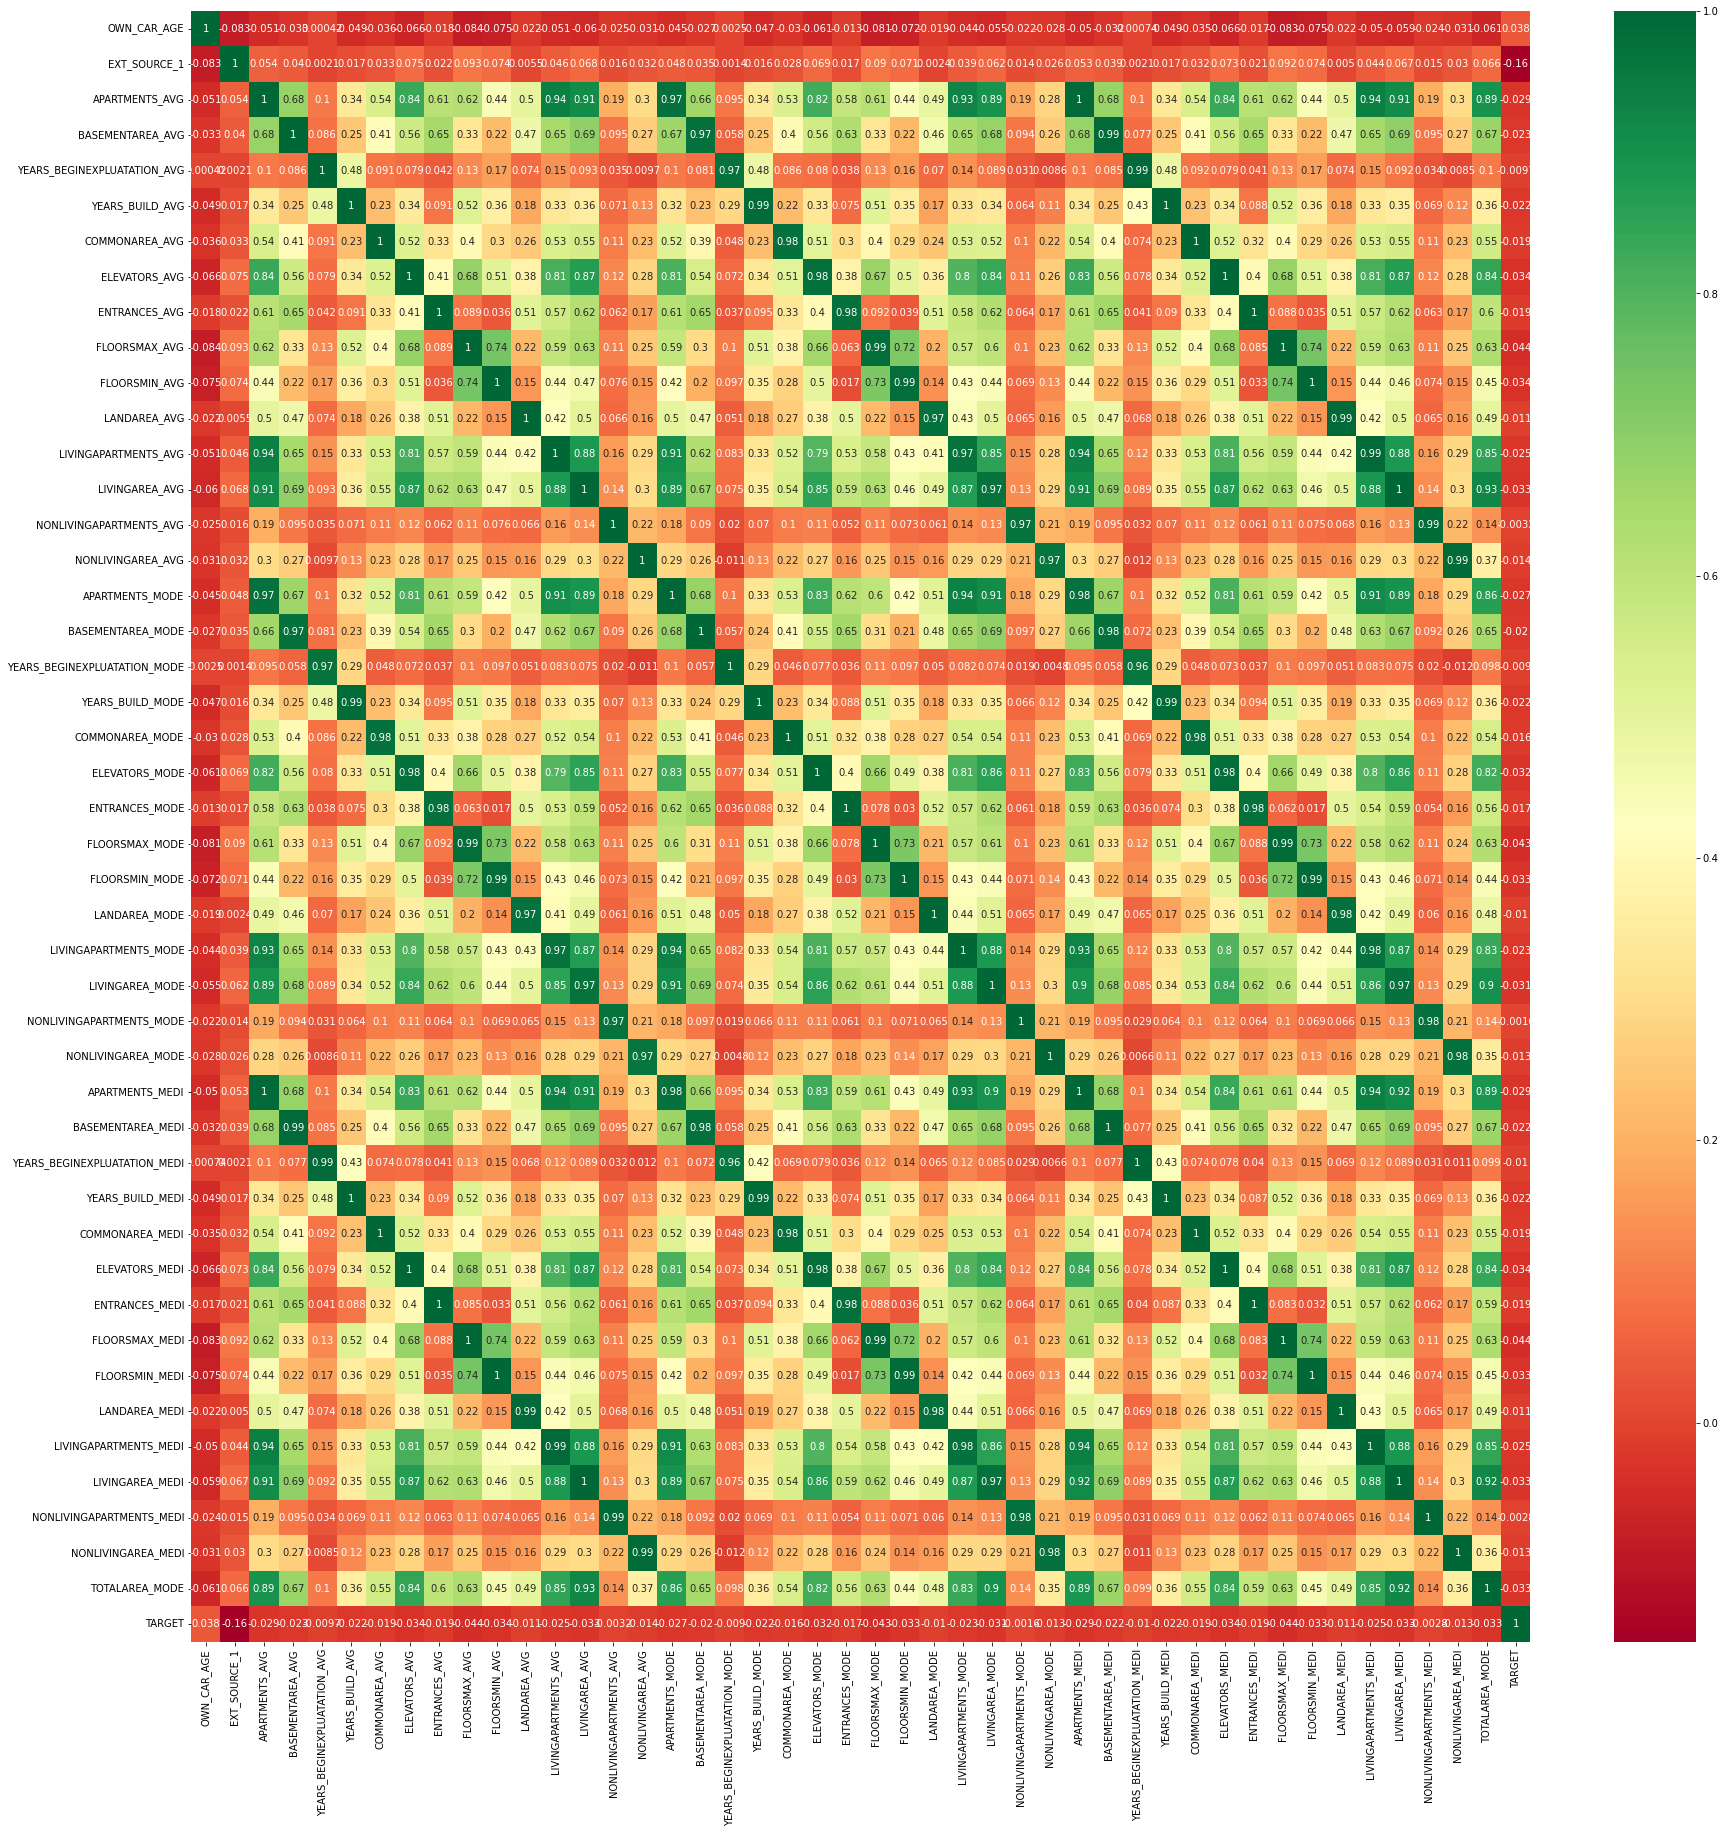

In [9]:
#Showing the correlation of missing_features_col vs TARGET column
fig = plt.figure(figsize=(30,30))
ax = sns.heatmap(missing_features_with_target_corr,
            xticklabels=missing_features_with_target_corr.columns,
            yticklabels=missing_features_with_target_corr.columns,
            annot = True,
            cmap ="RdYlGn")

> **Based on the above Heatmap, we see there is almost no correlation between missing_features and TARGET
thus we can drop them.**

In [10]:
#Dropping Columns over the 40% Threshold limit. 
application_data.drop(missing_features, axis=1, inplace=True)

In [11]:
#Checking Dataset after dropping.
application_data.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 73 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_CAR                 307511 non-null  object 
 5   FLAG_OWN_REALTY              307511 non-null  object 
 6   CNT_CHILDREN                 307511 non-null  int64  
 7   AMT_INCOME_TOTAL             307511 non-null  float64
 8   AMT_CREDIT                   307511 non-null  float64
 9   AMT_ANNUITY                  307499 non-null  float64
 10  AMT_GOODS_PRICE              307233 non-null  float64
 11  NAME_TYPE_SUITE              306219 non-null  object 
 12  NAME_INCOME_TYPE             307511 non-null  object 
 13 

In [12]:
#Selecting the residual features with missing Values.
residual_nulls=application_data.isnull().sum()/len(application_data)
residual_nul_col_list=residual_nulls[residual_nulls > 0.0].index
residual_nul_col=application_data[residual_nul_col_list]
residual_nul_col.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AMT_ANNUITY                 307499 non-null  float64
 1   AMT_GOODS_PRICE             307233 non-null  float64
 2   NAME_TYPE_SUITE             306219 non-null  object 
 3   OCCUPATION_TYPE             211120 non-null  object 
 4   CNT_FAM_MEMBERS             307509 non-null  float64
 5   EXT_SOURCE_2                306851 non-null  float64
 6   EXT_SOURCE_3                246546 non-null  float64
 7   OBS_30_CNT_SOCIAL_CIRCLE    306490 non-null  float64
 8   DEF_30_CNT_SOCIAL_CIRCLE    306490 non-null  float64
 9   OBS_60_CNT_SOCIAL_CIRCLE    306490 non-null  float64
 10  DEF_60_CNT_SOCIAL_CIRCLE    306490 non-null  float64
 11  DAYS_LAST_PHONE_CHANGE      307510 non-null  float64
 12  AMT_REQ_CREDIT_BUREAU_HOUR  265992 non-null  float64
 13  AMT_REQ_CREDIT

In [13]:
#Sorting by percentage of missing values.
residual_percent = application_data.isnull().sum()/application_data.shape[0]*100
residual_percent[residual_percent > 0].sort_values()

DAYS_LAST_PHONE_CHANGE         0.000325
CNT_FAM_MEMBERS                0.000650
AMT_ANNUITY                    0.003902
AMT_GOODS_PRICE                0.090403
EXT_SOURCE_2                   0.214626
DEF_60_CNT_SOCIAL_CIRCLE       0.332021
OBS_60_CNT_SOCIAL_CIRCLE       0.332021
DEF_30_CNT_SOCIAL_CIRCLE       0.332021
OBS_30_CNT_SOCIAL_CIRCLE       0.332021
NAME_TYPE_SUITE                0.420148
AMT_REQ_CREDIT_BUREAU_QRT     13.501631
AMT_REQ_CREDIT_BUREAU_HOUR    13.501631
AMT_REQ_CREDIT_BUREAU_DAY     13.501631
AMT_REQ_CREDIT_BUREAU_WEEK    13.501631
AMT_REQ_CREDIT_BUREAU_MON     13.501631
AMT_REQ_CREDIT_BUREAU_YEAR    13.501631
EXT_SOURCE_3                  19.825307
OCCUPATION_TYPE               31.345545
dtype: float64

### <div align="left"> <span style="color:brown"> <em></em> 4.3- Filling The Missing Data </span></div>
##### <div align="left"> <span style="color:brown"> <em></em> 4.3.1- Filling Numeric Data types </span></div>

In [14]:
# Let's get numeric
list_of_remaining_nul_1=['DAYS_LAST_PHONE_CHANGE','CNT_FAM_MEMBERS','AMT_ANNUITY','AMT_GOODS_PRICE','EXT_SOURCE_2','DEF_60_CNT_SOCIAL_CIRCLE',
'OBS_60_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_30_CNT_SOCIAL_CIRCLE',
'AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY'
,'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON',
'AMT_REQ_CREDIT_BUREAU_YEAR','EXT_SOURCE_3','OCCUPATION_TYPE']  
for i in list_of_remaining_nul_1:
    print(i,'>>',application_data[i].isnull().sum())

DAYS_LAST_PHONE_CHANGE >> 1
CNT_FAM_MEMBERS >> 2
AMT_ANNUITY >> 12
AMT_GOODS_PRICE >> 278
EXT_SOURCE_2 >> 660
DEF_60_CNT_SOCIAL_CIRCLE >> 1021
OBS_60_CNT_SOCIAL_CIRCLE >> 1021
DEF_30_CNT_SOCIAL_CIRCLE >> 1021
OBS_30_CNT_SOCIAL_CIRCLE >> 1021
AMT_REQ_CREDIT_BUREAU_QRT >> 41519
AMT_REQ_CREDIT_BUREAU_HOUR >> 41519
AMT_REQ_CREDIT_BUREAU_DAY >> 41519
AMT_REQ_CREDIT_BUREAU_WEEK >> 41519
AMT_REQ_CREDIT_BUREAU_MON >> 41519
AMT_REQ_CREDIT_BUREAU_YEAR >> 41519
EXT_SOURCE_3 >> 60965
OCCUPATION_TYPE >> 96391


In [15]:
#droping data entries for which 'DAYS_LAST_PHONE_CHANGE' and 'CNT_FAM_MEMBERS' values are missing as this count is Very low.
application_data.dropna(subset = ['DAYS_LAST_PHONE_CHANGE', 'CNT_FAM_MEMBERS'], inplace = True)

<Figure size 216x144 with 0 Axes>

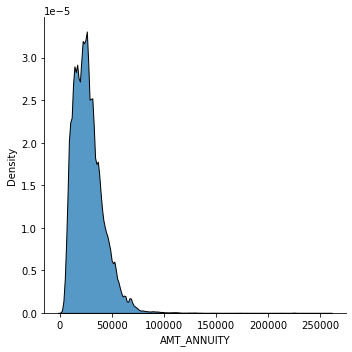

<Figure size 216x144 with 0 Axes>

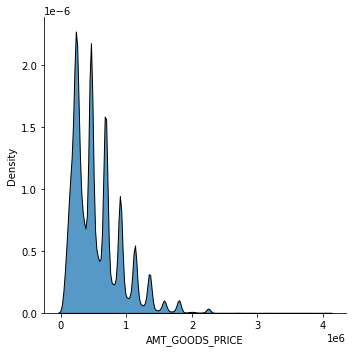

<Figure size 216x144 with 0 Axes>

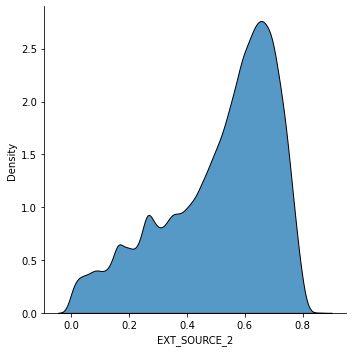

<Figure size 216x144 with 0 Axes>

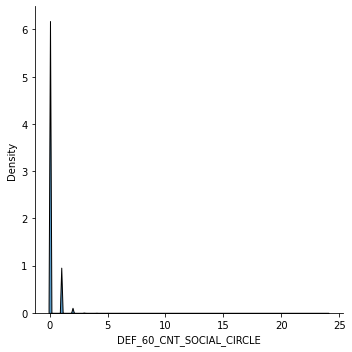

<Figure size 216x144 with 0 Axes>

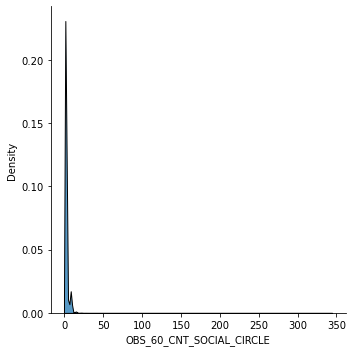

<Figure size 216x144 with 0 Axes>

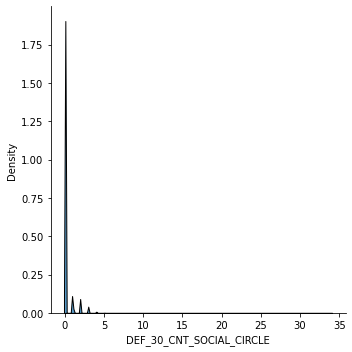

<Figure size 216x144 with 0 Axes>

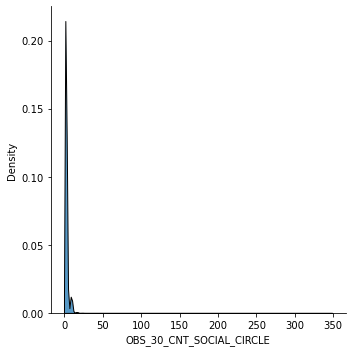

<Figure size 216x144 with 0 Axes>

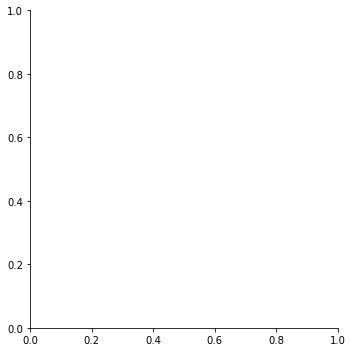

<Figure size 216x144 with 0 Axes>

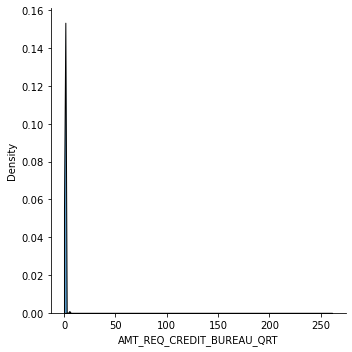

<Figure size 216x144 with 0 Axes>

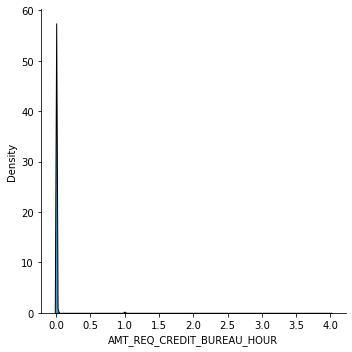

<Figure size 216x144 with 0 Axes>

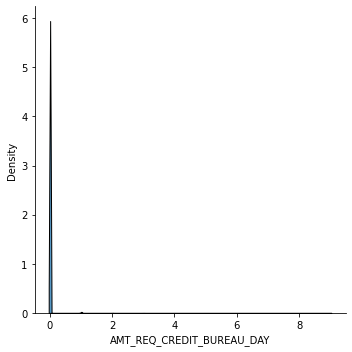

<Figure size 216x144 with 0 Axes>

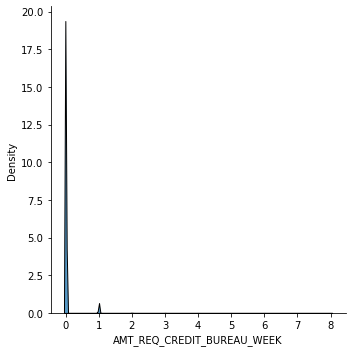

<Figure size 216x144 with 0 Axes>

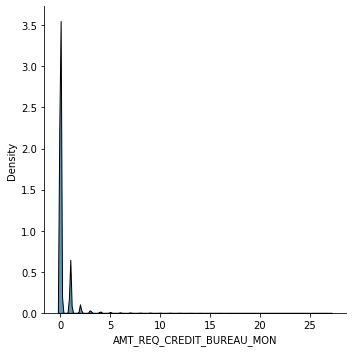

<Figure size 216x144 with 0 Axes>

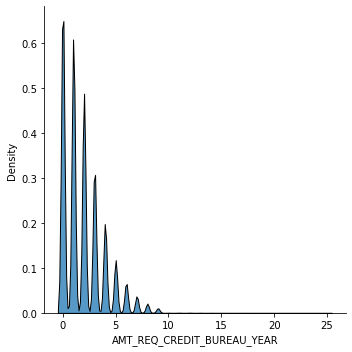

<Figure size 216x144 with 0 Axes>

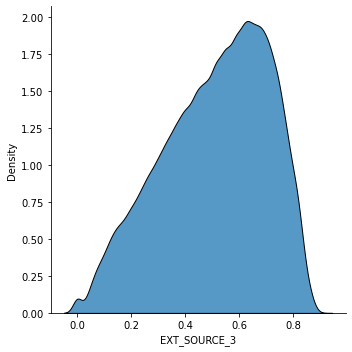

<Figure size 216x144 with 0 Axes>

In [16]:
list_of_remaining_nul_2=['AMT_ANNUITY','AMT_GOODS_PRICE','EXT_SOURCE_2','DEF_60_CNT_SOCIAL_CIRCLE',
'OBS_60_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_30_CNT_SOCIAL_CIRCLE','NAME_TYPE_SUITE',
'AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY'
,'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON',
'AMT_REQ_CREDIT_BUREAU_YEAR','EXT_SOURCE_3']  

for l in range(len(list_of_remaining_nul_2)+1):
    try:
        plt.figure(figsize = [3,2])
        sns.displot(application_data[list_of_remaining_nul_2[l]],kind="kde",multiple="stack")
        plt.show()
    except:
        l+=1

> **Distribution of amt_annuity, amt_goods_price shows skewness in data distribution se we will fill with median.**

In [17]:
# filling with median.
application_data.AMT_ANNUITY.fillna(application_data.AMT_ANNUITY.median(), inplace = True)
application_data.AMT_GOODS_PRICE.fillna(application_data.AMT_GOODS_PRICE.median(), inplace = True)

> **Distribution of def_60_cnt_social_circle, obs_60_cnt_social_circle, def_30_cnt_social_circle, obs_30_cnt_social_circle,
amt_req_credit_bureau_qrt, amt_req_credit_bureau_hour, amt_req_credit_bureau_day, amt_req_credit_bureau_week, amt_req_credit_bureau_mon, amt_req_credit_bureau_year eventhough it a quantitative variable, it is descrete and the distribution is highly skewed and therefore it makes sense to impute mode.**


In [18]:
# filling with Mode.
application_data.DEF_60_CNT_SOCIAL_CIRCLE.fillna(application_data.DEF_60_CNT_SOCIAL_CIRCLE.mode()[0], inplace = True)
application_data.OBS_60_CNT_SOCIAL_CIRCLE.fillna(application_data.OBS_60_CNT_SOCIAL_CIRCLE.mode()[0], inplace = True)
application_data.DEF_30_CNT_SOCIAL_CIRCLE.fillna(application_data.DEF_30_CNT_SOCIAL_CIRCLE.mode()[0], inplace = True)
application_data.OBS_30_CNT_SOCIAL_CIRCLE.fillna(application_data.OBS_30_CNT_SOCIAL_CIRCLE.mode()[0], inplace = True)
application_data.AMT_REQ_CREDIT_BUREAU_QRT.fillna(application_data.AMT_REQ_CREDIT_BUREAU_QRT.mode()[0], inplace = True)
application_data.AMT_REQ_CREDIT_BUREAU_HOUR.fillna(application_data.AMT_REQ_CREDIT_BUREAU_HOUR.mode()[0], inplace = True)
application_data.AMT_REQ_CREDIT_BUREAU_DAY.fillna(application_data.AMT_REQ_CREDIT_BUREAU_DAY.mode()[0], inplace = True)
application_data.AMT_REQ_CREDIT_BUREAU_WEEK.fillna(application_data.AMT_REQ_CREDIT_BUREAU_WEEK.mode()[0], inplace = True)
application_data.AMT_REQ_CREDIT_BUREAU_MON.fillna(application_data.AMT_REQ_CREDIT_BUREAU_MON.mode()[0], inplace = True)
application_data.AMT_REQ_CREDIT_BUREAU_YEAR.fillna(application_data.AMT_REQ_CREDIT_BUREAU_YEAR.mode()[0], inplace = True)

<blockquote>
<p><strong><font size="3">Distribution of ext_source_2, ext_source_3 shows that is not very skewed 
we will use median as these features aren't clear.

In [19]:
# filling with Median.
application_data.EXT_SOURCE_2.fillna(application_data.EXT_SOURCE_2.median(), inplace = True)
application_data.EXT_SOURCE_3.fillna(application_data.EXT_SOURCE_3.median(), inplace = True)

In [20]:
#Let's check the residual of nulls
residual_nulls2=application_data.isnull().sum()/len(application_data)
residual_nul_col_list3=residual_nulls2[residual_nulls2 > 0.0].index
residual_nul_col3=application_data[residual_nul_col_list3]
residual_nul_col3.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307508 entries, 0 to 307510
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   NAME_TYPE_SUITE  306218 non-null  object
 1   OCCUPATION_TYPE  211118 non-null  object
dtypes: object(2)
memory usage: 7.0+ MB


##### <div align="left"> <span style="color:brown"> <em></em> 4.3.2- Filling Categorical Data types </span></div>

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='NAME_TYPE_SUITE', ylabel='count'>

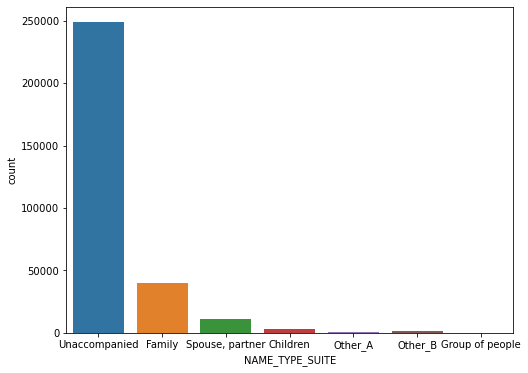

In [21]:
# lets plot first one
plt.figure(figsize = [8,6])
sns.countplot(application_data.NAME_TYPE_SUITE)

In [22]:
#We can simply fill NAME_TYPE_SUITE with Unaccompanied as it's the most frequent and highst count
application_data.NAME_TYPE_SUITE.fillna(application_data.NAME_TYPE_SUITE.mode()[0], inplace = True)

In [23]:
application_data.OCCUPATION_TYPE.value_counts()

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21370
Drivers                  18603
High skill tech staff    11380
Accountants               9812
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

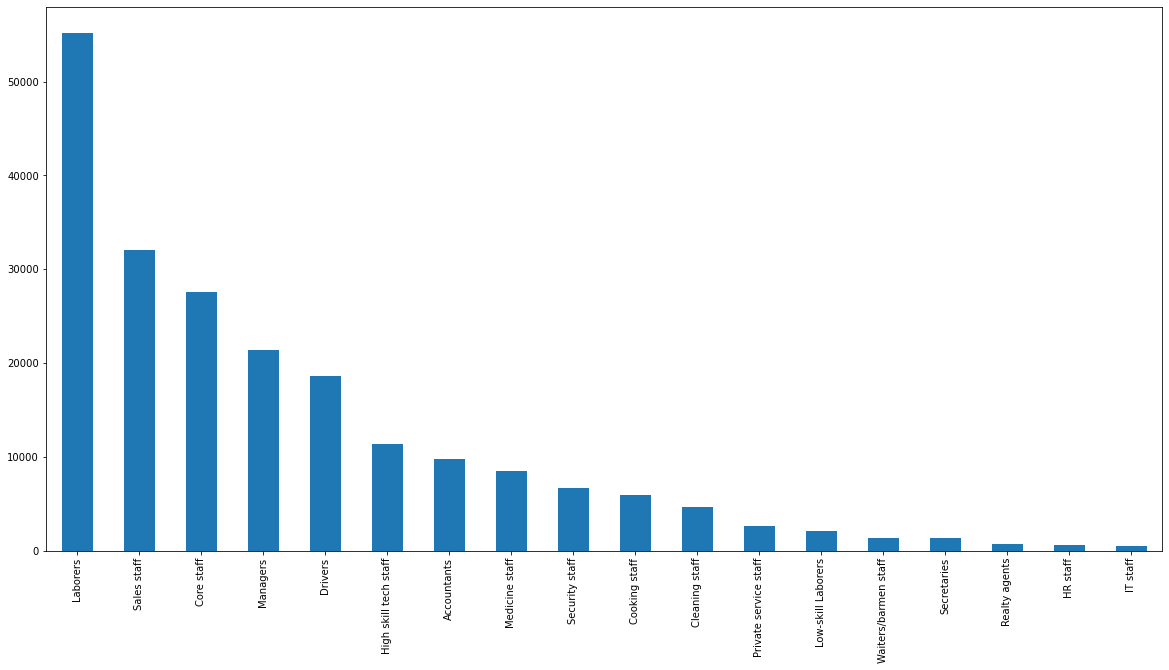

In [24]:
# lets plot second one
plt.figure(figsize = [20,10])
application_data.OCCUPATION_TYPE.value_counts().plot(kind="bar")
plt.show

In [25]:
#Let's fill with top most count values.
fill_list=['Laborers','Sales staff','Core staff','Managers']
application_data.OCCUPATION_TYPE.fillna(pd.Series(np.random.choice(fill_list, size=len(application_data.index))),inplace=True)

In [26]:
#Let's check if there's still any missing
residual_nulls2=application_data.isnull().sum()/len(application_data)
residual_nul_col_list3=residual_nulls2[residual_nulls2 > 0.0].index
residual_nul_col3=application_data[residual_nul_col_list3]
residual_nul_col3.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307508 entries, 0 to 307510
Empty DataFrame

In [27]:
#Check info
application_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307508 entries, 0 to 307510
Data columns (total 73 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307508 non-null  int64  
 1   TARGET                       307508 non-null  int64  
 2   NAME_CONTRACT_TYPE           307508 non-null  object 
 3   CODE_GENDER                  307508 non-null  object 
 4   FLAG_OWN_CAR                 307508 non-null  object 
 5   FLAG_OWN_REALTY              307508 non-null  object 
 6   CNT_CHILDREN                 307508 non-null  int64  
 7   AMT_INCOME_TOTAL             307508 non-null  float64
 8   AMT_CREDIT                   307508 non-null  float64
 9   AMT_ANNUITY                  307508 non-null  float64
 10  AMT_GOODS_PRICE              307508 non-null  float64
 11  NAME_TYPE_SUITE              307508 non-null  object 
 12  NAME_INCOME_TYPE             307508 non-null  object 
 13 

##### <div align="left"> <span style="color:brown"> <em></em> 4.4- Further Cleaning </span></div>

##### <div align="left"> <span style="color:brown"> <em></em> 4.4.1- Cleaning the categorical data types. </span></div>

In [28]:
#Let's get the categorical columns
application_data.select_dtypes(include=["object"]).columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object')

In [29]:
#Checking Gender values
application_data.CODE_GENDER.value_counts()

F      202447
M      105057
XNA         4
Name: CODE_GENDER, dtype: int64

In [30]:
#XNA seems like missing values we can fill with mode
application_data.CODE_GENDER.replace({'XNA':application_data.CODE_GENDER.mode()[0]},inplace=True)
application_data.CODE_GENDER.value_counts()

F    202451
M    105057
Name: CODE_GENDER, dtype: int64

In [31]:
#As we saw before that XNA is a missing value so we should replace it with nan instead.
application_data.replace({'XNA':np.nan}, inplace = True)

In [32]:
#Check dataset again to see if there' missing values
application_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307508 entries, 0 to 307510
Data columns (total 73 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307508 non-null  int64  
 1   TARGET                       307508 non-null  int64  
 2   NAME_CONTRACT_TYPE           307508 non-null  object 
 3   CODE_GENDER                  307508 non-null  object 
 4   FLAG_OWN_CAR                 307508 non-null  object 
 5   FLAG_OWN_REALTY              307508 non-null  object 
 6   CNT_CHILDREN                 307508 non-null  int64  
 7   AMT_INCOME_TOTAL             307508 non-null  float64
 8   AMT_CREDIT                   307508 non-null  float64
 9   AMT_ANNUITY                  307508 non-null  float64
 10  AMT_GOODS_PRICE              307508 non-null  float64
 11  NAME_TYPE_SUITE              307508 non-null  object 
 12  NAME_INCOME_TYPE             307508 non-null  object 
 13 

In [33]:
#Checking ORGANIZATION_TYPE values
application_data.ORGANIZATION_TYPE.value_counts()

Business Entity Type 3    67992
Self-employed             38412
Other                     16683
Medicine                  11193
Business Entity Type 2    10552
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6880
Construction               6721
Business Entity Type 1     5984
Transport: type 4          5398
Trade: type 3              3491
Industry: type 9           3368
Industry: type 3           3278
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7           1307
Transport: type 3          1187
Industry

In [34]:
#Let's fill ORGANIZATION_TYPE with top most count values.
fill_list_org=['Business Entity Type 3','Self-employed']
application_data.ORGANIZATION_TYPE.fillna(pd.Series(np.random.choice(fill_list_org, size=len(application_data.index))),inplace=True)

In [35]:
#Let's check nulls
application_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307508 entries, 0 to 307510
Data columns (total 73 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307508 non-null  int64  
 1   TARGET                       307508 non-null  int64  
 2   NAME_CONTRACT_TYPE           307508 non-null  object 
 3   CODE_GENDER                  307508 non-null  object 
 4   FLAG_OWN_CAR                 307508 non-null  object 
 5   FLAG_OWN_REALTY              307508 non-null  object 
 6   CNT_CHILDREN                 307508 non-null  int64  
 7   AMT_INCOME_TOTAL             307508 non-null  float64
 8   AMT_CREDIT                   307508 non-null  float64
 9   AMT_ANNUITY                  307508 non-null  float64
 10  AMT_GOODS_PRICE              307508 non-null  float64
 11  NAME_TYPE_SUITE              307508 non-null  object 
 12  NAME_INCOME_TYPE             307508 non-null  object 
 13 

##### <div align="left"> <span style="color:brown"> <em></em> 4.4.2- Cleaning the Negative Values. </span></div>

In [36]:
#Let's take a further look
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
application_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,0.535276,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.650442,0.535276,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.322738,0.535276,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


<blockquote>
<p><strong><font size="3">As it seems there is a Negative sign in columns of days we should turn to Positive </font></p>

In [37]:
#Taking absolute value for all these columns
application_data["DAYS_BIRTH"] = application_data["DAYS_BIRTH"].apply(lambda x: abs(x))
application_data["DAYS_EMPLOYED"] = application_data["DAYS_EMPLOYED"].apply(lambda x: abs(x))
application_data["DAYS_ID_PUBLISH"] = application_data["DAYS_ID_PUBLISH"].apply(lambda x: abs(x))
application_data["DAYS_LAST_PHONE_CHANGE"] =application_data["DAYS_LAST_PHONE_CHANGE"].apply(lambda x: abs(x))
application_data["DAYS_REGISTRATION"] = application_data["DAYS_REGISTRATION"].apply(lambda x: abs(x))
application_data[["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_ID_PUBLISH","DAYS_LAST_PHONE_CHANGE", "DAYS_REGISTRATION"]].head()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION
0,9461,637,2120,1134.0,3648.0
1,16765,1188,291,828.0,1186.0
2,19046,225,2531,815.0,4260.0
3,19005,3039,2437,617.0,9833.0
4,19932,3038,3458,1106.0,4311.0


In [38]:
#Function to get years from days
def days_age(days):
    tod = datetime.datetime.now()
    d = datetime.timedelta(days = days)
    a = tod - d
    return 2023-a.year

In [39]:
# Applying function to get years
application_data["DAYS_BIRTH"]=application_data["DAYS_BIRTH"].apply(days_age)
application_data["DAYS_EMPLOYED"]=application_data["DAYS_EMPLOYED"].apply(days_age)

##### <div align="left"> <span style="color:brown"> <em></em> 4.5- Exploratory Data Analysis  </span></div>

##### <div align="left"> <span style="color:brown"> <em></em> 4.5.1- TARGET DISTRIBUTION  </span></div>

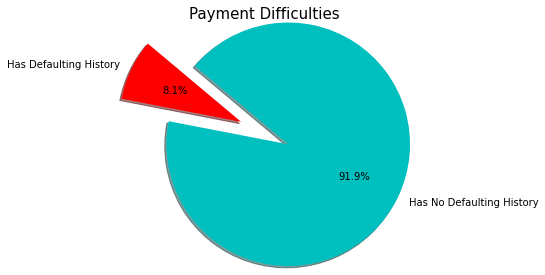

In [40]:
#Let's chart the target
d=[(application_data.loc[application_data['TARGET']==1].shape[0] / application_data.shape[0])*100,100-(application_data.loc[application_data['TARGET']==1].shape[0] / application_data.shape[0])*100]
fig1, ax1 = plt.subplots()
ax1.pie(d,labels=['Has Defaulting History','Has No Defaulting History'],explode = (0.3, 0.3), radius = 1.4,autopct='%1.1f%%',
        shadow=True, startangle=140, colors=['red', 'c'])
plt.title('Payment Difficulties', size=15)
plt.show()

In [41]:
get_desc('application_data','TARGET')

C:\Users\136861\AppData\Local\Temp\ipykernel_25532\524384844.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Table,Row,Description
1,application_data,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)"


##### <div align="left"> <span style="color:brown"> <em></em> 4.5.2-NUMERIC FEATURES ANALYSIS  </span></div>

<AxesSubplot:>

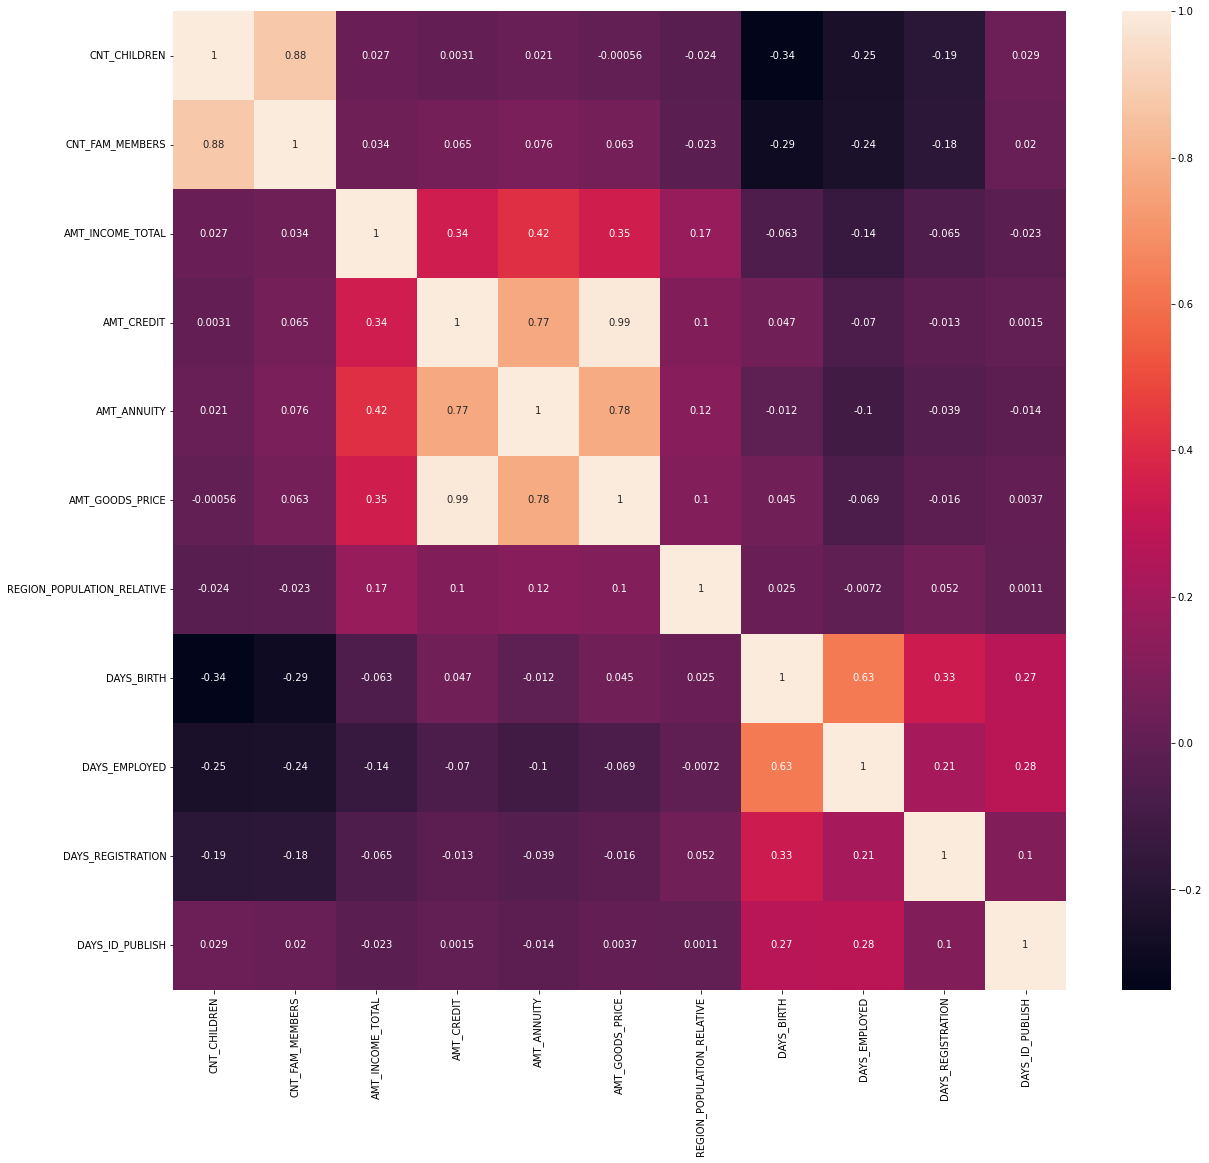

In [42]:
#Let's plot a heatmap of correlation matrix of relevant numerical variables for both defaulter and Non-defaulters.
target_0 = application_data.loc[application_data.TARGET == 0]
target_1 = application_data.loc[application_data.TARGET == 1]
plt.figure(figsize = [20,18])
#Plotting according to Defaulting
sns.heatmap(target_0[['CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED','DAYS_REGISTRATION', 
       'DAYS_ID_PUBLISH']].corr(), annot = True)

<AxesSubplot:>

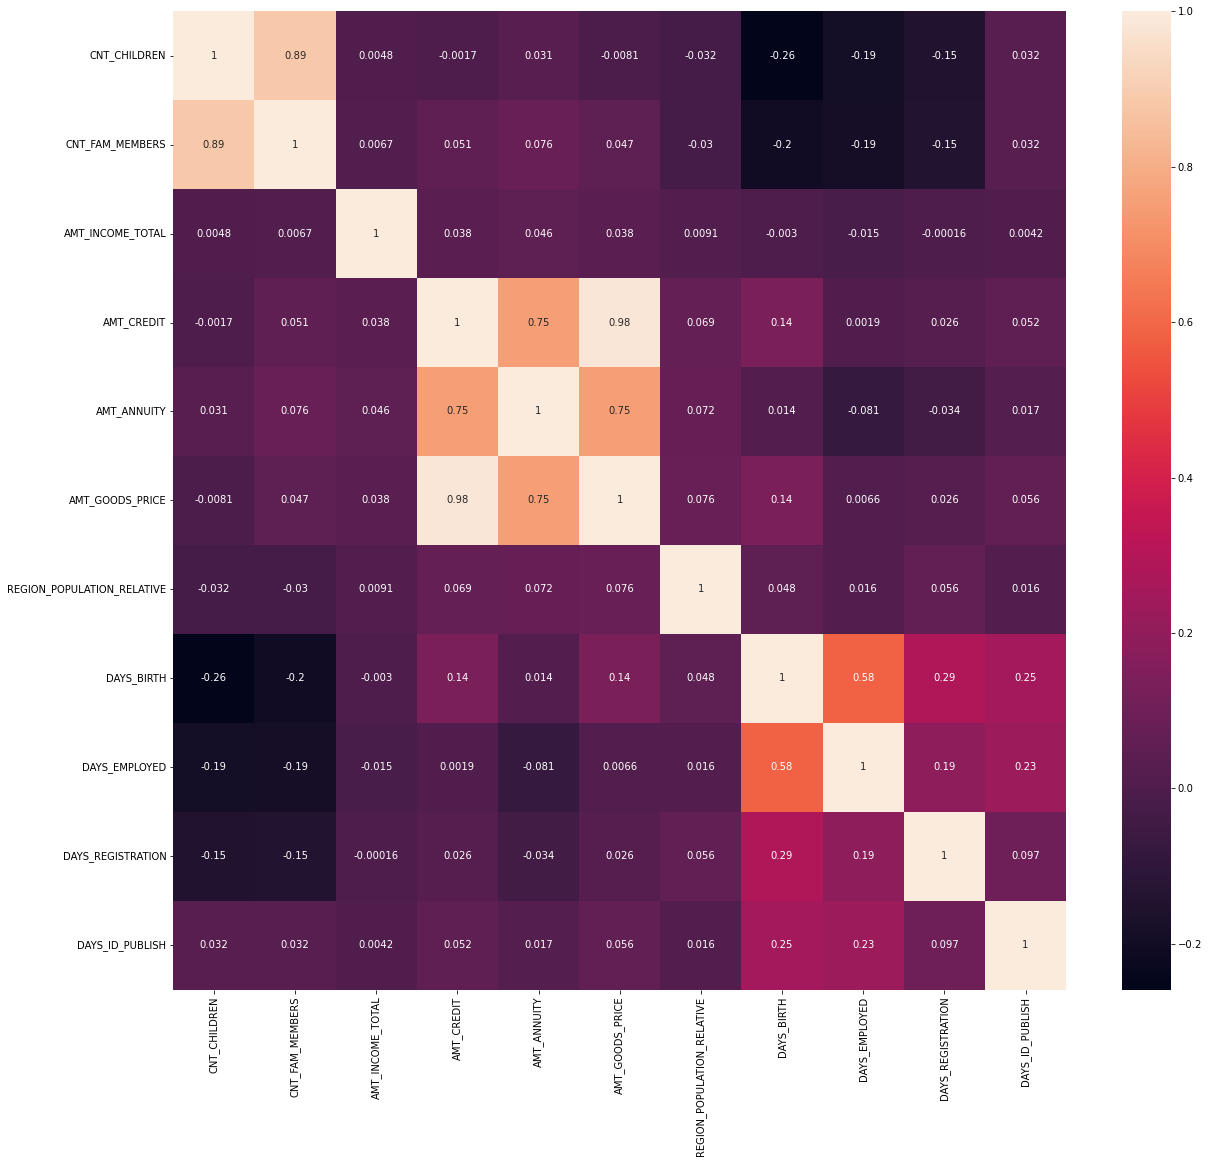

In [43]:
#Plotting according to Non Defaulting
plt.figure(figsize = [20,18])
sns.heatmap(target_1[['CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED','DAYS_REGISTRATION', 
       'DAYS_ID_PUBLISH']].corr(), annot = True)

<blockquote>
<p><strong><font size="4">Some Features have very small correlation in defaulters and a weak correlation for Non-defaulters   </font></p>

##### <div align="left"> <span style="color:brown"> <em></em> 4.5.3-CATEGORICAL FEATURES ANALYSIS  </span></div>

In [44]:
#Selecting Categorical Features
application_data.select_dtypes(include = ['object']).columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object')

In [45]:
#Education of Genders effect
application_data.groupby(['NAME_EDUCATION_TYPE','CODE_GENDER']).TARGET.mean().unstack()

CODE_GENDER,F,M
NAME_EDUCATION_TYPE,,
Academic degree,0.030000,0.000000
Higher education,0.048480,0.063932
Incomplete higher,0.080204,0.092184
Lower secondary,0.092601,0.134973
Secondary / secondary special,0.076749,0.113622


<blockquote>
<p><strong><font size="3">lower secondary education and secondary/secondary in Males seems to default  </font></p>

In [46]:
#Type of income for Genders
application_data.groupby(['NAME_INCOME_TYPE','CODE_GENDER']).TARGET.mean().unstack()

CODE_GENDER,F,M
NAME_INCOME_TYPE,,
Businessman,0.000000,0.000000
Commercial associate,0.066668,0.088279
Maternity leave,0.500000,0.000000
Pensioner,0.049557,0.073161
State servant,0.053418,0.068753
Student,0.000000,0.000000
Unemployed,0.352941,0.400000
Working,0.083733,0.114859


<blockquote>
<p><strong><font size="3">Unemployed Females and Females in Maternity leave seems to default  </font></p>

## <div align="left"> <span style="color:brown"> <em></em> _5- working on the previous_application Dataset_ </span></div>
### <div align="left"> <span style="color:brown"> <em></em> 5.1- Dataset Discovering </span></div>

In [47]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# Looks like there is 'XNA' and 'XAP' values need Replaced with NaN
previous_application.replace({'XNA':np.nan, 'XAP':np.nan}, inplace = True)

In [49]:
previous_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1669868 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

### <div align="left"> <span style="color:brown"> <em></em> 5.2- CATEGORICAL FEATURES ANALYSIS </span></div>

In [50]:
#Plotting Functions for plotting one feature count and two features against each other's count:
def plotting(x):
    with plt.style.context('seaborn-darkgrid'):
        cntplt = sns.countplot(previous_application[x], order = previous_application[x].value_counts().index)
        plt.xticks(rotation = 50, ha = 'right')
        cntplt.set_title('Distribution plot of {}'.format(x), fontsize = 13)
        for c in cntplt.patches:
            cntplt.annotate('{:.1f}%'.format(c.get_height()/previous_application[x].notnull().sum()*100),(c.get_x()+0.1, c.get_height()))
    plt.show()

def plotting_multi(x,y):
    with plt.style.context('seaborn-darkgrid'):
        cntplt = sns.countplot(previous_application[x], order = previous_application[x].value_counts().index, hue = previous_application[y])
        cntplt.set_title('Distribution plot of {}'.format(x), fontsize = 16)
        for k in cntplt.patches:
            cntplt.annotate('{:.1f}%'.format(k.get_height()/previous_application[x].notnull().sum()*100),(k.get_x()+0.05, k.get_height()))
    plt.show()
cat_previous=['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON',
       'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
       'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE',
       'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


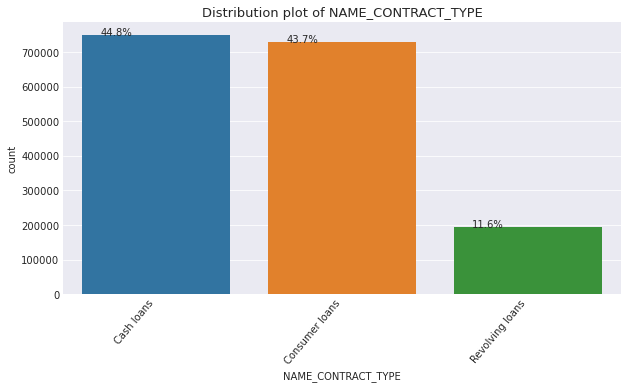

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


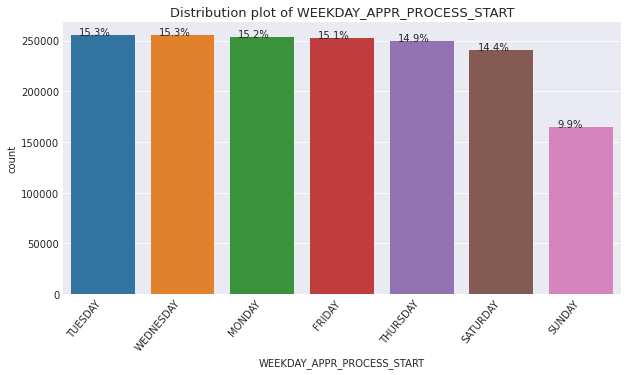

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


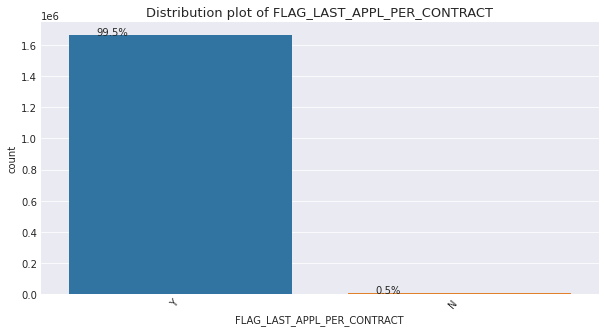

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


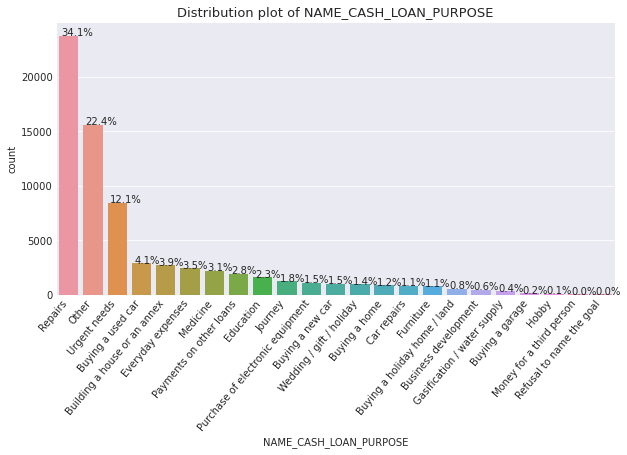

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


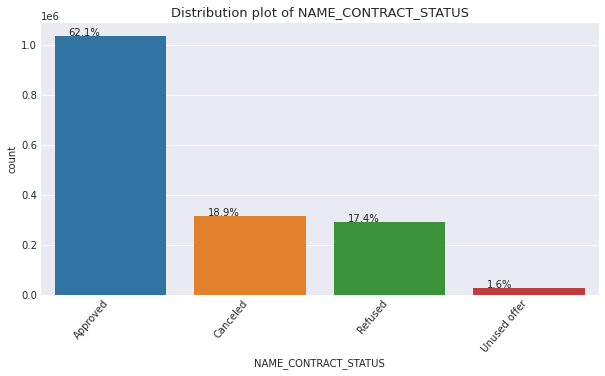

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


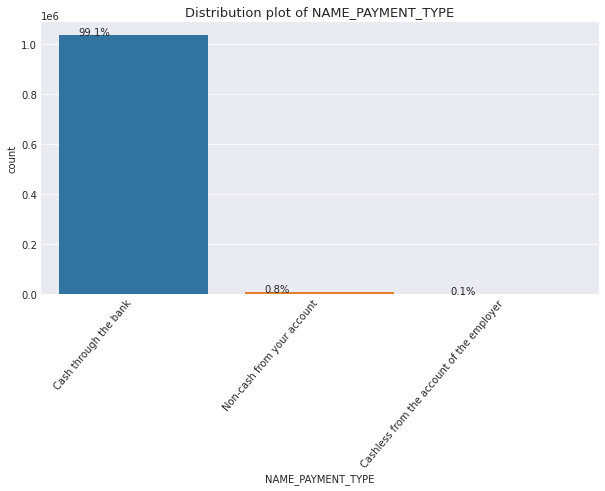

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


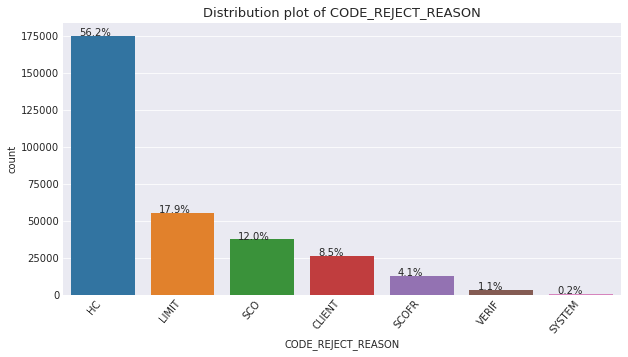

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


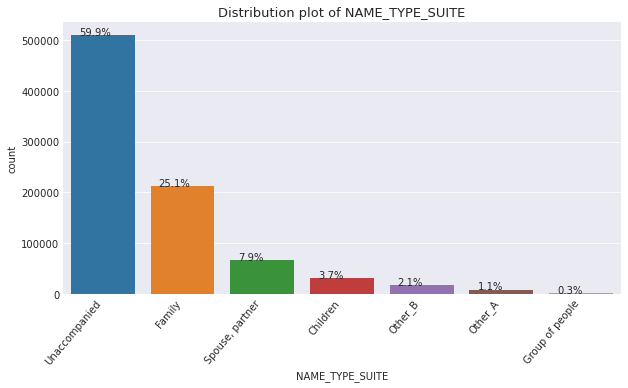

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


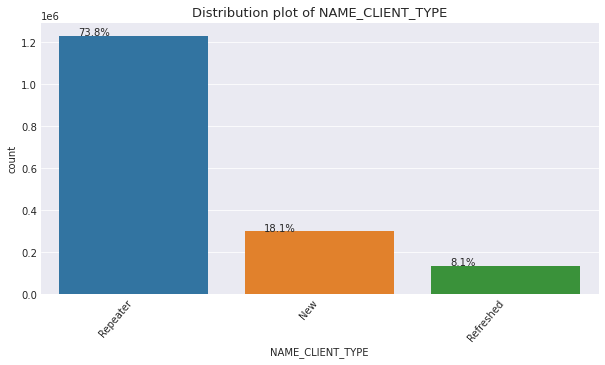

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


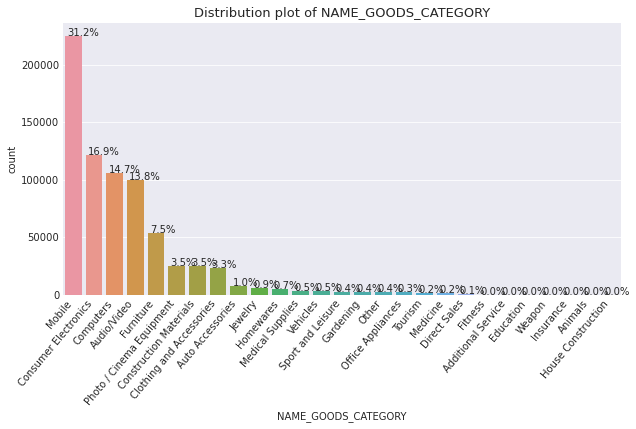

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


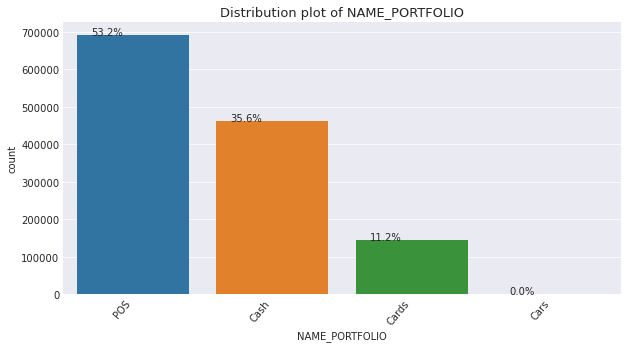

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


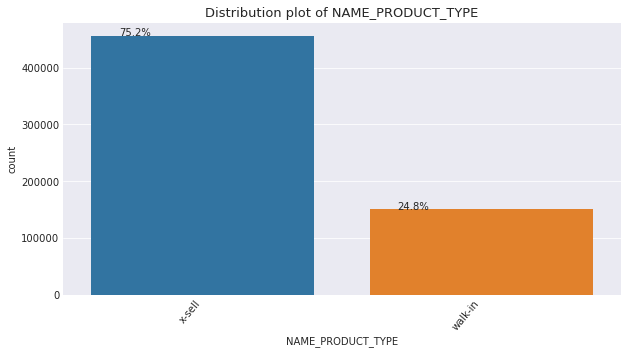

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


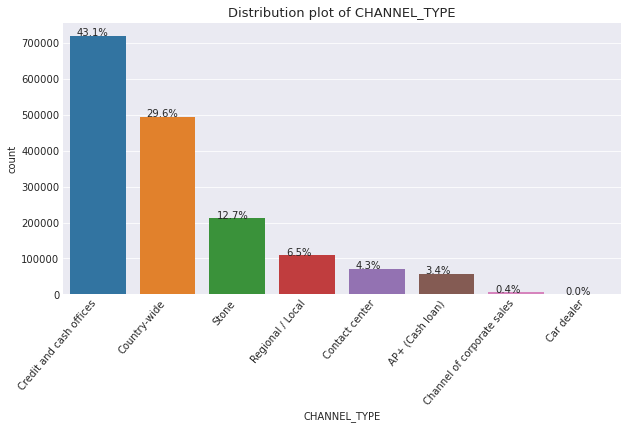

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


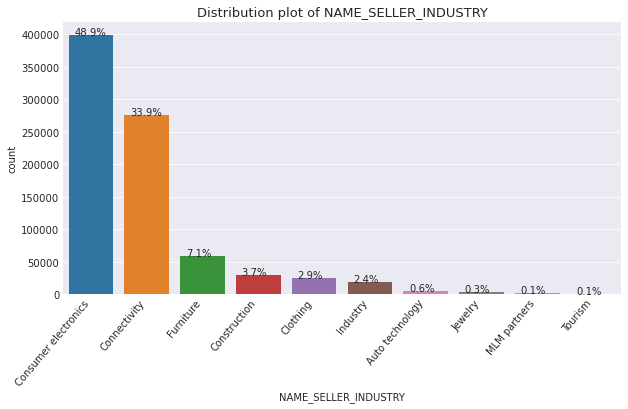

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


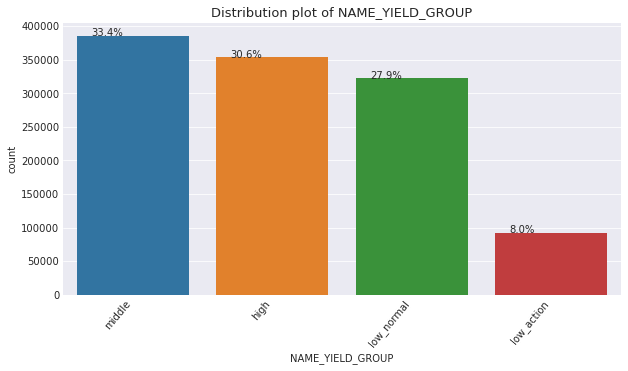

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


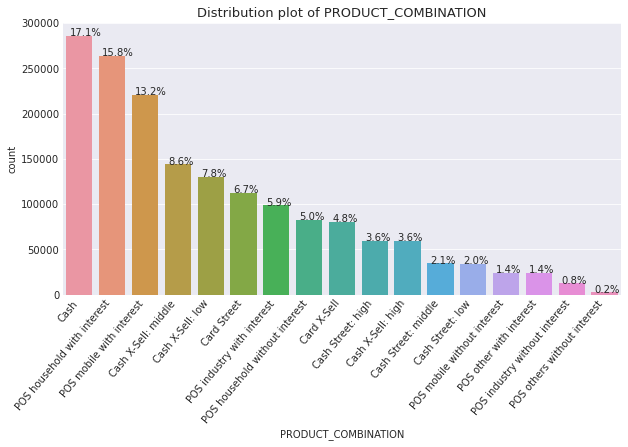

In [51]:
for cat in cat_previous:
    plt.figure(figsize = [10,5])
    plotting(cat)

<blockquote>
<p><strong><font size="3">Insights From One Feature Plots : 
<p><strong><font size="3">1-Most Contracts are Cash Loans and Consumer Loans.
<p><strong><font size="3">2-Process of Loaning is done in all weekdays as the same except Sunday.
<p><strong><font size="3">3-Purposes of loans mostly are for Repairs.
<p><strong><font size="3">4-Most old Contracts were Approved.
<p><strong><font size="3">5-Almost all the payments were made by Cash through bank.
<p><strong><font size="3">6-HC appears to be main reason for reject of application.
<p><strong><font size="3">7-Most of clients weren't accompanied when applying for the loan.
<p><strong><font size="3">7-Most of clients were Repeaters.
<p><strong><font size="3">8-Most of the previous loan application were for mobile, electronics and computers.
<p><strong><font size="3">9-Most of the clients were acquired through credit and cash office and country-wide channels.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


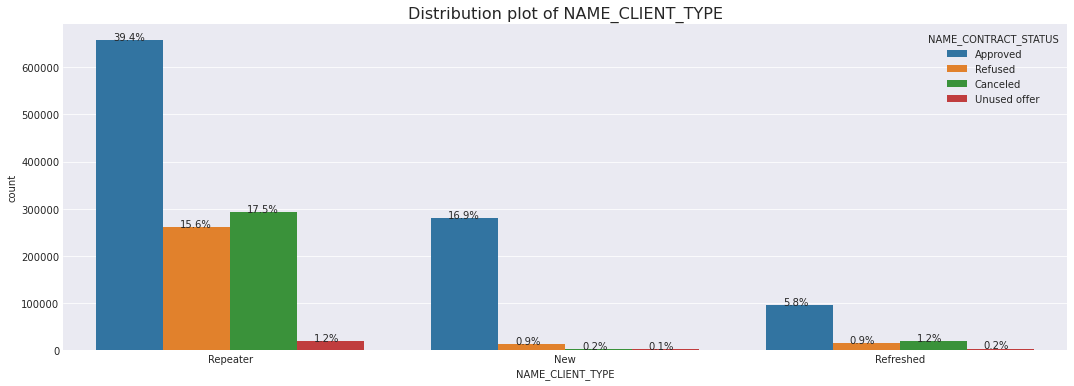

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


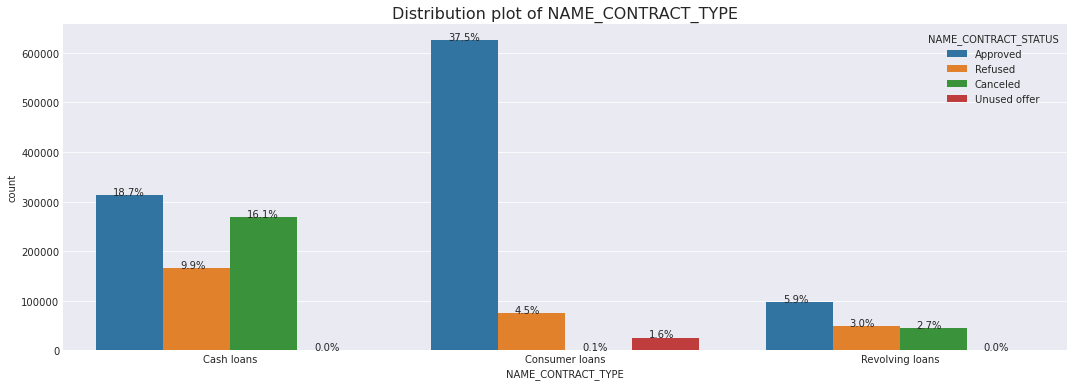

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


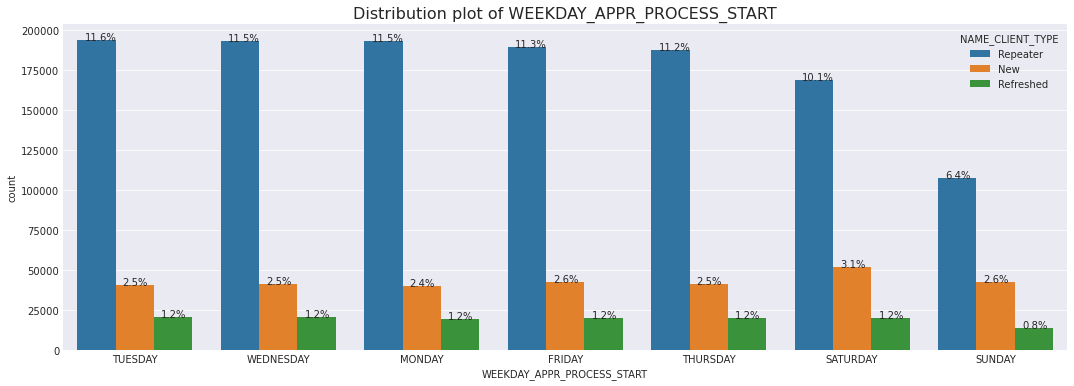

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


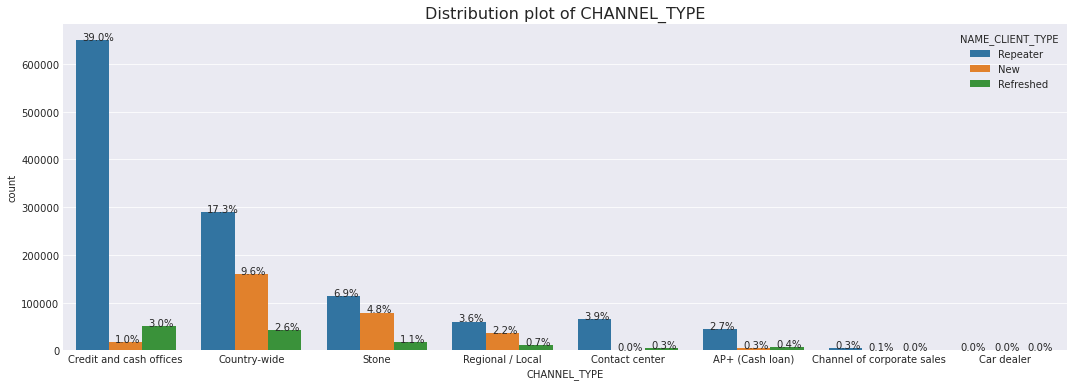

In [52]:
#Plotting Two Features against each other.
plt.figure(figsize = [18,6])
plotting_multi('NAME_CLIENT_TYPE', 'NAME_CONTRACT_STATUS')
plt.figure(figsize = [18,6])
plotting_multi('NAME_CONTRACT_TYPE', 'NAME_CONTRACT_STATUS')
plt.figure(figsize = [18,6])
plotting_multi('WEEKDAY_APPR_PROCESS_START', 'NAME_CLIENT_TYPE')
plt.figure(figsize = [18,6])
plotting_multi('CHANNEL_TYPE','NAME_CLIENT_TYPE')

<blockquote>
<p><strong><font size="3">Insights From Two Features Plots: 
<p><strong><font size="3">1-Most of Repeaters are approved also they are the most likely to be Refused and Cancelled Compared to others.
<p><strong><font size="3">2-Consumer loans are the Most approved although Cash loans are the highest count .
<p><strong><font size="3">3-Most of the new clients were from Country-wide channel and Repeaters were from cash offices.


### <div align="left"> <span style="color:brown"> <em></em> 5.3- NUMERICAL FEATURES ANALYSIS </span></div>

<AxesSubplot:xlabel='RATE_INTEREST_PRIVILEGED', ylabel='NAME_CONTRACT_STATUS'>

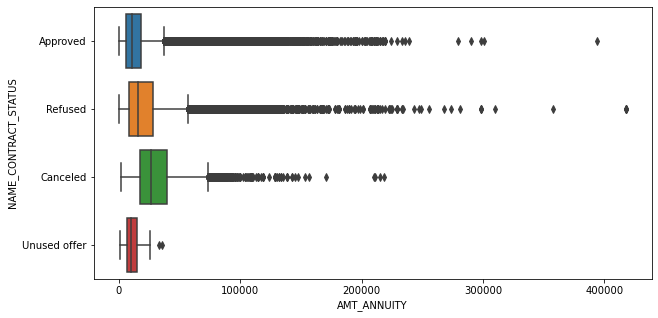

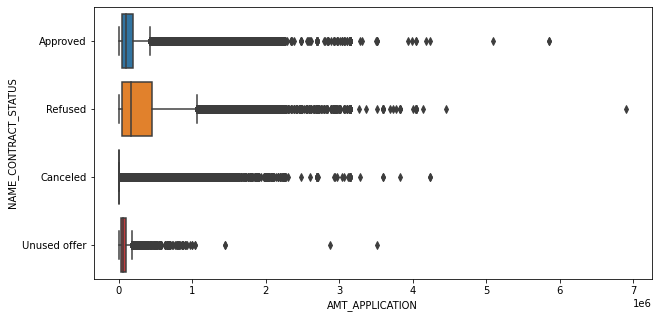

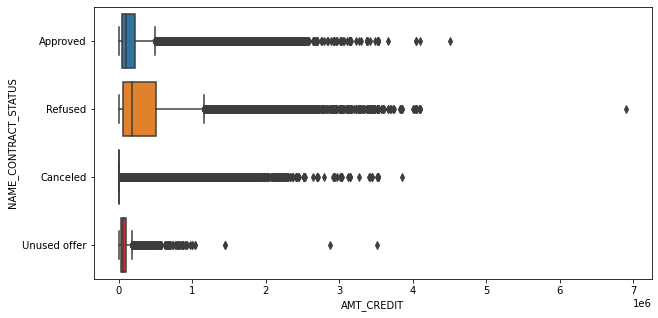

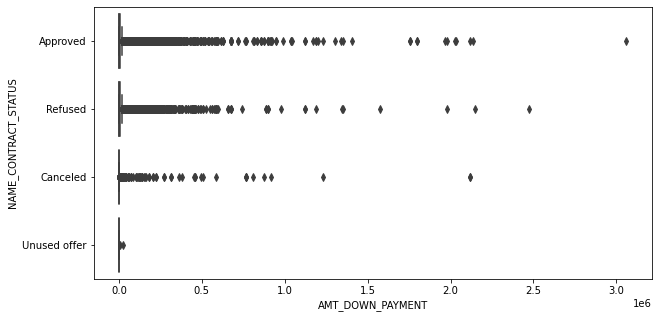

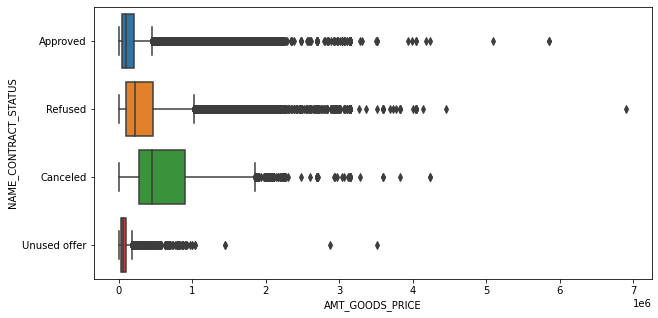

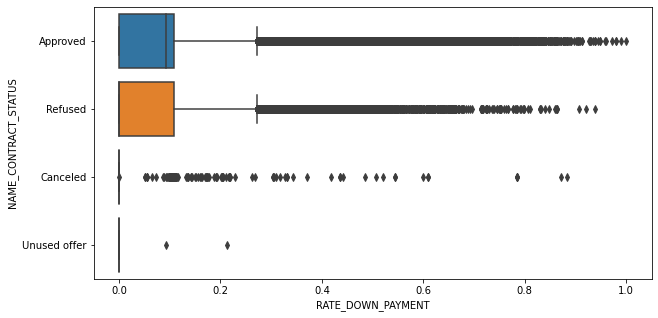

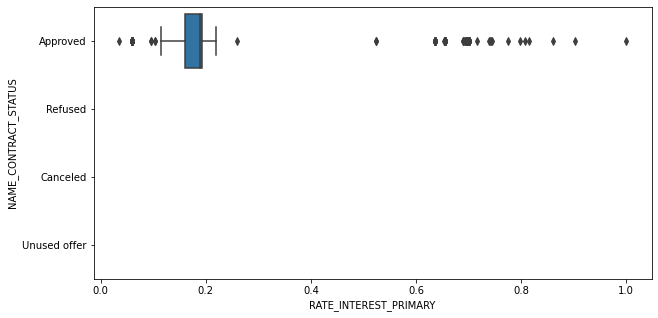

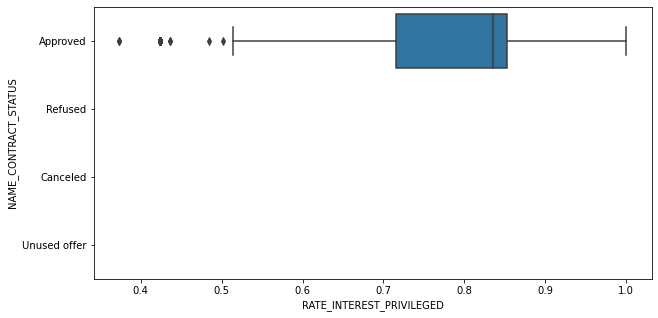

In [53]:
#Let's see the distribution
plt.figure(figsize = [10,5])
sns.boxplot(data=previous_application, x="AMT_ANNUITY", y="NAME_CONTRACT_STATUS")
plt.figure(figsize = [10,5])
sns.boxplot(data=previous_application, x="AMT_APPLICATION", y="NAME_CONTRACT_STATUS")
plt.figure(figsize = [10,5])
sns.boxplot(data=previous_application, x="AMT_CREDIT", y="NAME_CONTRACT_STATUS")
plt.figure(figsize = [10,5])
sns.boxplot(data=previous_application, x="AMT_DOWN_PAYMENT", y="NAME_CONTRACT_STATUS")
plt.figure(figsize = [10,5])
sns.boxplot(data=previous_application, x="AMT_GOODS_PRICE", y="NAME_CONTRACT_STATUS")
plt.figure(figsize = [10,5])
sns.boxplot(data=previous_application, x="RATE_DOWN_PAYMENT", y="NAME_CONTRACT_STATUS")
plt.figure(figsize = [10,5])
sns.boxplot(data=previous_application, x="RATE_INTEREST_PRIMARY", y="NAME_CONTRACT_STATUS")
plt.figure(figsize = [10,5])
sns.boxplot(data=previous_application, x="RATE_INTEREST_PRIVILEGED", y="NAME_CONTRACT_STATUS")

In [54]:
get_desc('previous_application.csv','AMT_CREDIT')

C:\Users\136861\AppData\Local\Temp\ipykernel_25532\524384844.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Table,Row,Description
127,previous_application.csv,AMT_CREDIT,"Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT"


<blockquote>
<p><strong><font size="3">Insights From Numerical Features: 
<p><strong><font size="3">1-AMT CREDIT and ANNUITY were lower in approved loans and higher in the refused.
<p><strong><font size="3">2-Goods Prices that was high were most likely to be refused than lower ones.
<p><strong><font size="3">3-All of these features has outliers


## <div align="left"> <span style="color:brown"> <em></em> _5- Working on partial Merge Dataset of Both Datasets_ </span></div>
### <div align="left"> <span style="color:brown"> <em></em> 5.1- Dataset Discovering </span></div>

In [55]:
#Merging on SK_ID_CURR and just getting target and gender from the application dataset for analysis
df=pd.merge(application_data[['SK_ID_CURR','TARGET','CODE_GENDER']], previous_application, on = 'SK_ID_CURR', how = 'inner')

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1413701 entries, 0 to 1413700
Data columns (total 39 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_CURR                   1413701 non-null  int64  
 1   TARGET                       1413701 non-null  int64  
 2   CODE_GENDER                  1413701 non-null  object 
 3   SK_ID_PREV                   1413701 non-null  int64  
 4   NAME_CONTRACT_TYPE           1413388 non-null  object 
 5   AMT_ANNUITY                  1106483 non-null  float64
 6   AMT_APPLICATION              1413701 non-null  float64
 7   AMT_CREDIT                   1413700 non-null  float64
 8   AMT_DOWN_PAYMENT             664161 non-null   float64
 9   AMT_GOODS_PRICE              1094176 non-null  float64
 10  WEEKDAY_APPR_PROCESS_START   1413701 non-null  object 
 11  HOUR_APPR_PROCESS_START      1413701 non-null  int64  
 12  FLAG_LAST_APPL_PER_CONTRACT  1413701 non-n

### <div align="left"> <span style="color:brown"> <em></em> 5.2- Dataset Analysis </span></div>

In [57]:
#Plotting Function
def plotting_new(x, y, val):
    with plt.style.context('seaborn-deep'):
        cntplott = sns.countplot(df.loc[df.TARGET == val, x], order = df.loc[df.TARGET == val, x].value_counts().index, hue = df[y])
        cntplott.set_title('Distr. plot of {}'.format(x), fontsize = 16)
        for c in cntplott.patches:
            cntplott.annotate('{:.1f}%'.format(c.get_height()/df.loc[df.TARGET == val, x].notnull().sum()*100),(c.get_x()+0.05, c.get_height()))
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


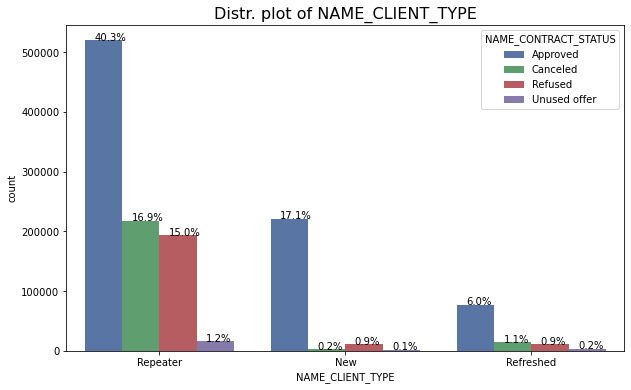

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


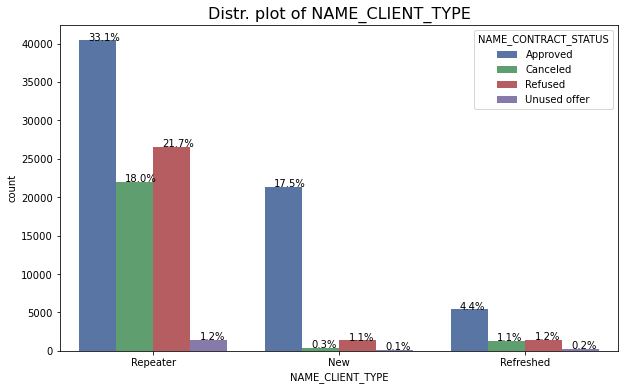

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


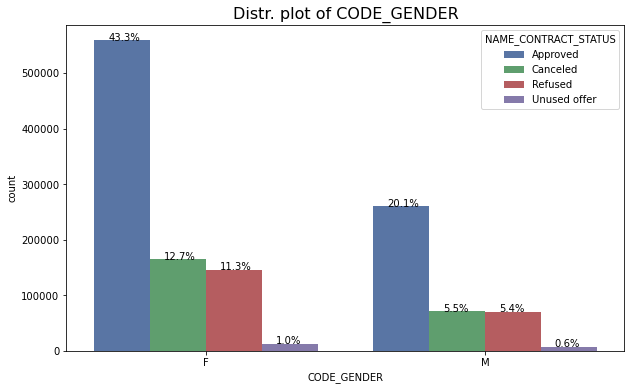

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


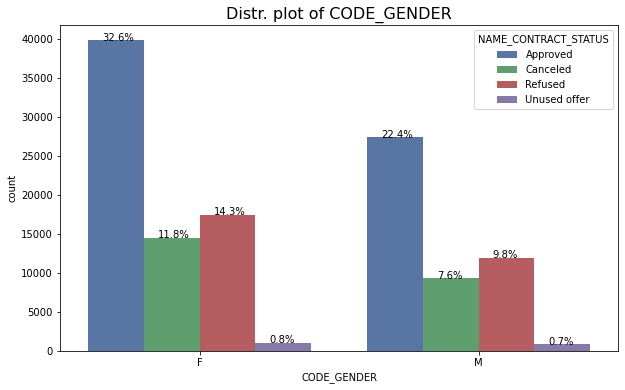

In [58]:
#plotting according to defaulting and non defaulting
plt.figure(figsize = [10,6])
plotting_new('NAME_CLIENT_TYPE', 'NAME_CONTRACT_STATUS', 0) # NAME_CLIENT_TYPE NON-Defaulters
plt.figure(figsize = [10,6])
plotting_new('NAME_CLIENT_TYPE', 'NAME_CONTRACT_STATUS', 1) # NAME_CLIENT_TYPE Defaulters
plt.figure(figsize = [10,6])
plotting_new('CODE_GENDER', 'NAME_CONTRACT_STATUS', 0) # CODE_GENDER NON-Defaulters
plt.figure(figsize = [10,6])
plotting_new('CODE_GENDER', 'NAME_CONTRACT_STATUS', 1) # CODE_GENDER Defaulters

<blockquote>
<p><strong><font size="3">Insights Merged Dataset Plots: 
<p><strong><font size="3">1-Repeaters that are defaulters have most refused and cancelled than non_defaulters.
<p><strong><font size="3">2-Deafulters in Mens get cancelled and refused than non defaulters.

## <div align="left"> <span style="color:brown"> <em></em> _6- Working on All Merged Dataset of Both Datasets_ </span></div>
### <div align="left"> <span style="color:brown"> <em></em> 5.1- Dataset Discovering </span></div>

In [59]:
df_all=pd.merge(application_data, previous_application, on = 'SK_ID_CURR', how = 'inner')

In [60]:
df_all.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,NAME_TYPE_SUITE_x,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_x,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV,NAME_CONTRACT_TYPE_y,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE_y,WEEKDAY_APPR_PROCESS_START_y,HOUR_APPR_PROCESS_START_y,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE_y,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,26,2,3648.0,2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,2.0,2.0,2.0,2.0,1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1038818,Consumer loans,9251.775,179055.0,179055.0,0.0,179055.0,SATURDAY,9,Y,1,0.000000,NaN,NaN,NaN,Approved,-606,NaN,NaN,NaN,New,Vehicles,POS,NaN,Stone,500,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,46,4,1186.0,291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,0.535276,1.0,0.0,1.0,0.0,828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1810518,Cash loans,98356.995,900000.0,1035882.0,NaN,900000.0,FRIDAY,12,Y,1,NaN,NaN,NaN,NaN,Approved,-746,NaN,NaN,Unaccompanied,Repeater,NaN,Cash,x-sell,Credit and cash offices,-1,NaN,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
2,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,46,4,1186.0,291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,0.535276,1.0,0.0,1.0,0.0,828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2636178,Consumer loans,64567.665,337500.0,348637.5,0.0,337500.0,SUNDAY,17,Y,1,0.000000,NaN,NaN,NaN,Approved,-828,Cash through the bank,NaN,Family,Refreshed,Furniture,POS,NaN,Stone,1400,Furniture,6.0,middle,POS industry with interest,365243.0,-797.0,-647.0,-647.0,-639.0,0.0
3,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,46,4,1186.0,291,1,1,0,1,1,0,Core 

### <div align="left"> <span style="color:brown"> <em></em> 5.2- Data Cleaning and Filling Missing for Merged DF </span></div>

In [61]:
#Checking missing values
nulls_merged_df = round(df_all.isnull().sum()/df_all.shape[0]*100, 2)
nulls_merged_df[nulls_merged_df > 0]

NAME_CONTRACT_TYPE_y         0.02 
AMT_ANNUITY_y                21.73
AMT_DOWN_PAYMENT             53.02
AMT_GOODS_PRICE_y            22.60
RATE_DOWN_PAYMENT            53.02
RATE_INTEREST_PRIMARY        99.66
RATE_INTEREST_PRIVILEGED     99.66
NAME_CASH_LOAN_PURPOSE       95.80
NAME_PAYMENT_TYPE            36.99
CODE_REJECT_REASON           81.34
NAME_TYPE_SUITE_y            49.14
NAME_CLIENT_TYPE             0.11 
NAME_GOODS_CATEGORY          56.39
NAME_PORTFOLIO               21.73
NAME_PRODUCT_TYPE            63.67
NAME_SELLER_INDUSTRY         50.60
CNT_PAYMENT                  21.73
NAME_YIELD_GROUP             30.36
PRODUCT_COMBINATION          0.02 
DAYS_FIRST_DRAWING           39.69
DAYS_FIRST_DUE               39.69
DAYS_LAST_DUE_1ST_VERSION    39.69
DAYS_LAST_DUE                39.69
DAYS_TERMINATION             39.69
NFLAG_INSURED_ON_APPROVAL    39.69
dtype: float64

In [62]:
#Dropping Features with more than 40 % Missing
cols = [col for col in df_all.columns if df_all[col].isna().sum()/df_all.shape[0] > 0.4]
df_all.drop(cols, axis = 1, inplace = True)
df_all.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,NAME_TYPE_SUITE_x,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_x,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV,NAME_CONTRACT_TYPE_y,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,WEEKDAY_APPR_PROCESS_START_y,HOUR_APPR_PROCESS_START_y,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,NAME_CLIENT_TYPE,NAME_PORTFOLIO,CHANNEL_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,26,2,3648.0,2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,2.0,2.0,2.0,2.0,1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1038818,Consumer loans,9251.775,179055.0,179055.0,179055.0,SATURDAY,9,Y,1,Approved,-606,NaN,New,POS,Stone,500,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,46,4,1186.0,291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,0.535276,1.0,0.0,1.0,0.0,828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1810518,Cash loans,98356.995,900000.0,1035882.0,900000.0,FRIDAY,12,Y,1,Approved,-746,NaN,Repeater,Cash,Credit and cash offices,-1,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
2,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,46,4,1186.0,291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,0.535276,1.0,0.0,1.0,0.0,828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2636178,Consumer loans,64567.665,337500.0,348637.5,337500.0,SUNDAY,17,Y,1,Approved,-828,Cash through the bank,Refreshed,POS,Stone,1400,6.0,middle,POS industry with interest,365243.0,-797.0,-647.0,-647.0,-639.0,0.0
3,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,46,4,1186.0,291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,0.535276,1.0,0.0,1.0,0.0,828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2396755,Consumer loans,6737.310,68809.5,68053.5,68809.5,SATURDAY,15,Y,1,Approved,-2341,Cash through the bank,Refreshed,POS,Country-wide,200,12.0,middle,POS household with interest,365243.0,-2310.0,-1980.0,-1980.0,-1976.0,1.0
4,10

In [63]:
#Filling Categorical Features with Mode.
col_catt_new = ['OCCUPATION_TYPE','ORGANIZATION_TYPE','NAME_CONTRACT_TYPE_y','NAME_PAYMENT_TYPE', 'NAME_CLIENT_TYPE', 
        'NAME_PORTFOLIO','NAME_YIELD_GROUP', 'PRODUCT_COMBINATION','NFLAG_INSURED_ON_APPROVAL']
for i in col_catt_new:
    df_all[i] = df_all[i].fillna(df_all[i].mode()[0])

In [64]:
#Filling Numerical Features with Mean & Median 
col_num_new1 = ['AMT_ANNUITY_y', 'AMT_GOODS_PRICE_y']
for i in col_num_new1:
    df_all[i] = df_all[i].fillna(df_all[i].mean())
col_num_new2 = ['CNT_PAYMENT', 'DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION']
for i in col_num_new2:
    df_all[i] = df_all[i].fillna(df_all[i].mean())
df_all.dropna(axis = 0, inplace = True)

In [65]:
df_all.isna().any()

SK_ID_CURR                      False
TARGET                          False
NAME_CONTRACT_TYPE_x            False
CODE_GENDER                     False
FLAG_OWN_CAR                    False
FLAG_OWN_REALTY                 False
CNT_CHILDREN                    False
AMT_INCOME_TOTAL                False
AMT_CREDIT_x                    False
AMT_ANNUITY_x                   False
AMT_GOODS_PRICE_x               False
NAME_TYPE_SUITE_x               False
NAME_INCOME_TYPE                False
NAME_EDUCATION_TYPE             False
NAME_FAMILY_STATUS              False
NAME_HOUSING_TYPE               False
REGION_POPULATION_RELATIVE      False
DAYS_BIRTH                      False
DAYS_EMPLOYED                   False
DAYS_REGISTRATION               False
DAYS_ID_PUBLISH                 False
FLAG_MOBIL                      False
FLAG_EMP_PHONE                  False
FLAG_WORK_PHONE                 False
FLAG_CONT_MOBILE                False
FLAG_PHONE                      False
FLAG_EMAIL  

## <div align="left"> <span style="color:brown"> <em></em> _7- Feature Engineering_ </span></div>
### <div align="left"> <span style="color:brown"> <em></em> 7.1- Cleaning Features </span></div>

In [66]:
#Dropping IDs as they aren't helpful for model
df_all.drop(['SK_ID_CURR', 'SK_ID_PREV'], axis = 1, inplace = True)

In [67]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1413700 entries, 0 to 1413700
Data columns (total 97 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   TARGET                        1413700 non-null  int64  
 1   NAME_CONTRACT_TYPE_x          1413700 non-null  object 
 2   CODE_GENDER                   1413700 non-null  object 
 3   FLAG_OWN_CAR                  1413700 non-null  object 
 4   FLAG_OWN_REALTY               1413700 non-null  object 
 5   CNT_CHILDREN                  1413700 non-null  int64  
 6   AMT_INCOME_TOTAL              1413700 non-null  float64
 7   AMT_CREDIT_x                  1413700 non-null  float64
 8   AMT_ANNUITY_x                 1413700 non-null  float64
 9   AMT_GOODS_PRICE_x             1413700 non-null  float64
 10  NAME_TYPE_SUITE_x             1413700 non-null  object 
 11  NAME_INCOME_TYPE              1413700 non-null  object 
 12  NAME_EDUCATION_TYPE         

In [68]:
#columns to be changed to category type as It looks and behaves like a string in many instances but internally is represented by an array of integers
flag_colss = ['FLAG_MOBIL',
 'FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE',
 'FLAG_PHONE','FLAG_EMAIL','REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY','REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21',
 'NFLAG_INSURED_ON_APPROVAL']
df_all[flag_colss] = df_all[flag_colss].astype('category')

In [69]:
#Selecting categorical and Numerical features
categorical_columns_merged = [col for col in df_all.select_dtypes(include = ['object', 'category']).columns]
numerical_columns_merged = [col for col in df_all.select_dtypes(include = np.number).columns if col != 'TARGET']

In [70]:
#creating dummy variables for catagorical features
dummy_df = pd.get_dummies(df_all[categorical_columns_merged], drop_first = True)
df_all.head()

,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,NAME_TYPE_SUITE_x,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_x,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_y,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,WEEKDAY_APPR_PROCESS_START_y,HOUR_APPR_PROCESS_START_y,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,NAME_CLIENT_TYPE,NAME_PORTFOLIO,CHANNEL_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,26,2,3648.0,2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,2.0,2.0,2.0,2.0,1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,Consumer loans,9251.775,179055.0,179055.0,179055.0,SATURDAY,9,Y,1,Approved,-606,Cash through the bank,New,POS,Stone,500,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,46,4,1186.0,291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,0.535276,1.0,0.0,1.0,0.0,828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,Cash loans,98356.995,900000.0,1035882.0,900000.0,FRIDAY,12,Y,1,Approved,-746,Cash through the bank,Repeater,Cash,Credit and cash offices,-1,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
2,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,46,4,1186.0,291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,0.535276,1.0,0.0,1.0,0.0,828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,Consumer loans,64567.665,337500.0,348637.5,337500.0,SUNDAY,17,Y,1,Approved,-828,Cash through the bank,Refreshed,POS,Stone,1400,6.0,middle,POS industry with interest,365243.0,-797.0,-647.0,-647.0,-639.0,0.0
3,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,46,4,1186.0,291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,0.535276,1.0,0.0,1.0,0.0,828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,Consumer loans,6737.310,68809.5,68053.5,68809.5,SATURDAY,15,Y,1,Approved,-2341,Cash through the bank,Refreshed,POS,Country-wide,200,12.0,middle,POS household with interest,365243.0,-2310.0,-1980.0,-1980.0,-1976.0,1.0
4,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.

In [71]:
#concatenating the dummies with merged_data and overwriting merged_data.
df_all = pd.concat([df_all, dummy_df], axis = 1)

In [72]:
#dropping old catagorical columns as dummies have been created for them
df_all.drop(categorical_columns_merged, axis = 1, inplace = True)

In [73]:
df_all.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START_x,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,HOUR_APPR_PROCESS_START_y,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NAME_CONTRACT_TYPE_x_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_x_Family,NAME_TYPE_SUITE_x_Group of people,NAME_TYPE_SUITE_x_Other_A,NAME_TYPE_SUITE_x_Other_B,"NAME_TYPE_SUITE_x_Spouse, partner",NAME_TYPE_SUITE_x_Unaccompanied,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,FLAG_EMP_PHONE_1,FLAG_WORK_PHONE_1,FLAG_CONT_MOBILE_1,FLAG_PHONE_1,FLAG_EMAIL_1,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,REGION_RATING_CLIENT_2,REGION_RATING_CLIENT_3,REGION_RATING_CLIENT_W_CITY_2,REGION_RATING_CLIENT_W_CITY_3,WEEKDAY_APPR_PROCESS_START_x_MONDAY,WEEKDAY_APPR_PROCESS_START_x_SATURDAY,WEEKDAY_APPR_PROCESS_START_x_SUNDAY,WEEKDAY_APPR_PROCESS_START_x_THURSDAY,WEEKDAY_APPR_PROCESS_START_x_TUESDAY,WEEKDAY_APPR_PROCESS_START_x_WEDNESDAY,REG_REGION_NOT_LIVE_REGION_1,REG_REGION_NOT_WORK_REGION_1,LIVE_REGION_NOT_WORK_REGION_1,REG_CITY_NOT_LIVE_CITY_1,REG_CITY_NOT_WORK_CITY_1,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Minist

In [74]:
#Converting Negative to Positive
df_all["DAYS_DECISION"] = df_all["DAYS_DECISION"].apply(lambda x: abs(x))
df_all["DAYS_FIRST_DUE"] = df_all["DAYS_FIRST_DUE"].apply(lambda x: abs(x))
df_all["DAYS_LAST_DUE_1ST_VERSION"] = df_all["DAYS_LAST_DUE_1ST_VERSION"].apply(lambda x: abs(x))
df_all["DAYS_LAST_DUE"] =df_all["DAYS_LAST_DUE"].apply(lambda x: abs(x))
df_all["DAYS_TERMINATION"] = df_all["DAYS_TERMINATION"].apply(lambda x: abs(x))
df_all[["DAYS_DECISION", "DAYS_FIRST_DUE", "DAYS_LAST_DUE_1ST_VERSION","DAYS_LAST_DUE", "DAYS_TERMINATION"]].head()

,DAYS_DECISION,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION
0,606,565.0,125.0,25.0,17.0
1,746,716.0,386.0,536.0,527.0
2,828,797.0,647.0,647.0,639.0
3,2341,2310.0,1980.0,1980.0,1976.0
4,815,784.0,694.0,724.0,714.0


In [75]:
df_all.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START_x,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,HOUR_APPR_PROCESS_START_y,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NAME_CONTRACT_TYPE_x_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_x_Family,NAME_TYPE_SUITE_x_Group of people,NAME_TYPE_SUITE_x_Other_A,NAME_TYPE_SUITE_x_Other_B,"NAME_TYPE_SUITE_x_Spouse, partner",NAME_TYPE_SUITE_x_Unaccompanied,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,FLAG_EMP_PHONE_1,FLAG_WORK_PHONE_1,FLAG_CONT_MOBILE_1,FLAG_PHONE_1,FLAG_EMAIL_1,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,REGION_RATING_CLIENT_2,REGION_RATING_CLIENT_3,REGION_RATING_CLIENT_W_CITY_2,REGION_RATING_CLIENT_W_CITY_3,WEEKDAY_APPR_PROCESS_START_x_MONDAY,WEEKDAY_APPR_PROCESS_START_x_SATURDAY,WEEKDAY_APPR_PROCESS_START_x_SUNDAY,WEEKDAY_APPR_PROCESS_START_x_THURSDAY,WEEKDAY_APPR_PROCESS_START_x_TUESDAY,WEEKDAY_APPR_PROCESS_START_x_WEDNESDAY,REG_REGION_NOT_LIVE_REGION_1,REG_REGION_NOT_WORK_REGION_1,LIVE_REGION_NOT_WORK_REGION_1,REG_CITY_NOT_LIVE_CITY_1,REG_CITY_NOT_WORK_CITY_1,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Minist

### <div align="left"> <span style="color:brown"> <em></em> 7.2- Sampling and Splitting Data </span></div>

In [76]:
#Taking a sample of Dataset as it's clearly a very large dataset.
#We choose random sampling method as Sampling error is lowest in this method out of all the methods.
df_all_sample = df_all.sample(10000)

In [77]:
#Seprating features from target
X = df_all_sample.drop('TARGET', axis = 1)
y = df_all_sample['TARGET']

In [78]:
#splitting into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state = 1)

In [79]:
X_train.shape, X_test.shape

((7000, 228), (3000, 228))

### <div align="left"> <span style="color:brown"> <em></em> 7.3- Feature Scaling </span></div>

In [80]:
#Scaling using standard scaler to standardise the numerical features it makes mean = 0 and scales the data to unit variance
scaler = StandardScaler()
X_train[numerical_columns_merged] = scaler.fit_transform(X_train[numerical_columns_merged])
X_test[numerical_columns_merged] = scaler.transform(X_test[numerical_columns_merged])

In [81]:
#mean and std of numrical columns after standard scaling
X_train[numerical_columns_merged].agg([np.mean, np.std]).round(2)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START_x,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,HOUR_APPR_PROCESS_START_y,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION
mean,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### <div align="left"> <span style="color:brown"> <em></em> 7.3.1- Metrics Before Feature Selection </span></div>

LogisticRegression Model Accuracy: 91.3 %
LogisticRegression Model Precision: 36.8 %
LogisticRegression Model Sensitivity: 2.7 %
LogisticRegression Model AUC: 51.14312909691595 %
LogisticRegression Model Specificity: 99.5625227852716 %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


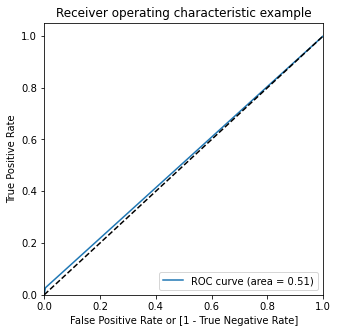

In [82]:
#LogisticRegression
model1=LogisticRegression(random_state=0)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
accuracy_score1=accuracy_score(y_test, y_pred1)
print(f'LogisticRegression Model Accuracy: {round(accuracy_score1*100 , 1)} %') 
#Precision measures true positives over the number of total positives
print(f'LogisticRegression Model Precision: {round(precision_score(y_test,y_pred1)*100 , 1)} %')
#Recall measures true positive over the count of actual positive outcomes.
print(f'LogisticRegression Model Sensitivity: {round(recall_score(y_test,y_pred1)*100 , 1)} %') 
print(f'LogisticRegression Model AUC: {metrics.roc_auc_score( y_test, y_pred1 )*100} %') 
confusion1 = metrics.confusion_matrix(y_test, y_pred1 )
TP = confusion1[1,1] # True Positiv 
TN = confusion1[0,0] # True Negative
FP = confusion1[0,1] # False Positive
FN = confusion1[1,0] # False Negative
print(f'LogisticRegression Model Specificity: {(TN / float(TN+FP))*100 } %') 
#The model precision score measures the proportion of positively predicted labels that are actually correct
#Model recall score represents the model’s ability to correctly predict the positives out of actual positives
#A confusion matrix is used to describe performance of classific. model on data for which the true values are known.
fpr, tpr, thresholds = metrics.roc_curve( y_test, y_pred1,drop_intermediate = False )
auc_score = metrics.roc_auc_score( y_test, y_pred1 )
plt.figure(figsize=(5, 5))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

DecisionTreeRegressor Model Accuracy: 84.6 %
DecisionTreeRegressor Model Precision: 14.6 %
DecisionTreeRegressor Model Sensitivity: 16.3 %
DecisionTreeRegressor Model AUC: 53.68706477471484 %
DecisionTreeRegressor Model Specificity: 91.03171709806782 %


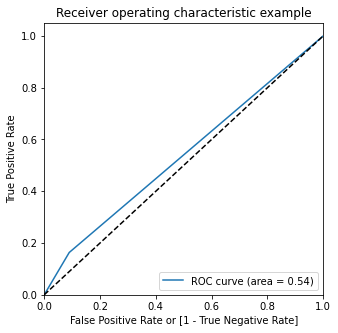

In [83]:
#DecisionTreeRegressor
model2=DecisionTreeRegressor(random_state = 0)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
accuracy_score2=accuracy_score(y_test, y_pred2)
print(f'DecisionTreeRegressor Model Accuracy: {round(accuracy_score2*100 , 1)} %') 
print(f'DecisionTreeRegressor Model Precision: {round(precision_score(y_test,y_pred2)*100 , 1)} %') 
print(f'DecisionTreeRegressor Model Sensitivity: {round(recall_score(y_test,y_pred2)*100 , 1)} %') 
print(f'DecisionTreeRegressor Model AUC: {metrics.roc_auc_score( y_test, y_pred2 )*100} %') 
confusion2 = metrics.confusion_matrix(y_test, y_pred2 )
TP = confusion2[1,1] # True Positiv 
TN = confusion2[0,0] # True Negative
FP = confusion2[0,1] # False Positive
FN = confusion2[1,0] # False Negative
print(f'DecisionTreeRegressor Model Specificity: {(TN / float(TN+FP))*100 } %') 
fpr, tpr, thresholds = metrics.roc_curve( y_test, y_pred2,drop_intermediate = False )
auc_score = metrics.roc_auc_score( y_test, y_pred2 )
plt.figure(figsize=(5, 5))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

RandomForestClassifier Model Accuracy: 91.5 %
RandomForestClassifier Model Precision: 100.0 %
RandomForestClassifier Model Sensitivity: 1.2 %
RandomForestClassifier Model AUC: 50.583657587548636 %
RandomForestClassifier Model Specificity: 100.0 %


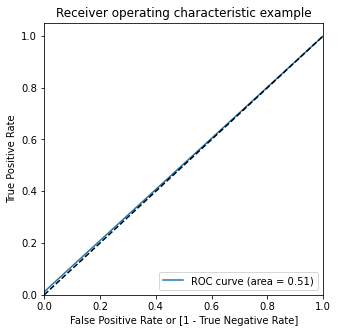

In [84]:
#RandomForestClassifier
model3=RandomForestClassifier(random_state = 0)
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
accuracy_score3=accuracy_score(y_test, y_pred3)
print(f'RandomForestClassifier Model Accuracy: {round(accuracy_score3*100 , 1)} %') 
print(f'RandomForestClassifier Model Precision: {round(precision_score(y_test,y_pred3)*100 , 1)} %') 
print(f'RandomForestClassifier Model Sensitivity: {round(recall_score(y_test,y_pred3)*100 , 1)} %') 
print(f'RandomForestClassifier Model AUC: {metrics.roc_auc_score( y_test, y_pred3 )*100} %') 
confusion3 = metrics.confusion_matrix(y_test, y_pred3 )
TP = confusion3[1,1] # True Positiv 
TN = confusion3[0,0] # True Negative
FP = confusion3[0,1] # False Positive
FN = confusion3[1,0] # False Negative
print(f'RandomForestClassifier Model Specificity: {(TN / float(TN+FP))*100 } %') 
fpr, tpr, thresholds = metrics.roc_curve( y_test, y_pred3,drop_intermediate = False )
auc_score = metrics.roc_auc_score( y_test, y_pred3 )
plt.figure(figsize=(5, 5))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

XGBClassifier Model Accuracy: 91.1 %
XGBClassifier Model Precision: 36.1 %
XGBClassifier Model Sensitivity: 5.1 %
XGBClassifier Model AUC: 52.10993388192938 %
XGBClassifier Model Specificity: 99.1615020051039 %


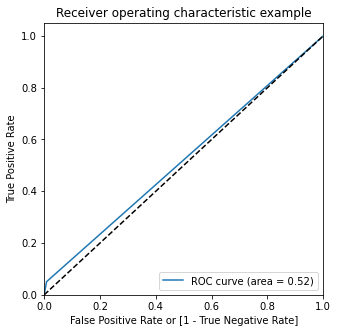

In [85]:
#XGBClassifier
model4=XGBClassifier(random_state=0)
model4.fit(X_train, y_train)
y_pred4 = model4.predict(X_test)
accuracy_score4=accuracy_score(y_test, y_pred4)
print(f'XGBClassifier Model Accuracy: {round(accuracy_score4*100 , 1)} %') 
print(f'XGBClassifier Model Precision: {round(precision_score(y_test,y_pred4)*100 , 1)} %') 
print(f'XGBClassifier Model Sensitivity: {round(recall_score(y_test,y_pred4)*100 , 1)} %')
print(f'XGBClassifier Model AUC: {metrics.roc_auc_score( y_test, y_pred4 )*100} %') 
confusion4 = metrics.confusion_matrix(y_test, y_pred4 )
TP = confusion4[1,1] # True Positiv 
TN = confusion4[0,0] # True Negative
FP = confusion4[0,1] # False Positive
FN = confusion4[1,0] # False Negative
print(f'XGBClassifier Model Specificity: {(TN / float(TN+FP))*100 } %') 
fpr, tpr, thresholds = metrics.roc_curve( y_test, y_pred4,drop_intermediate = False )
auc_score = metrics.roc_auc_score( y_test, y_pred4 )
plt.figure(figsize=(5, 5))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

KNeighborsClassifier Model Accuracy: 90.2 %
KNeighborsClassifier Model Precision: 23.6 %
KNeighborsClassifier Model Recall: 6.6 %
KNeighborsClassifier Model AUC: 52.3048410456897 %
KNeighborsClassifier Model Specificity: 97.9948960991615 %
KNeighborsClassifier Model Sensitivity: 6.614785992217899 %


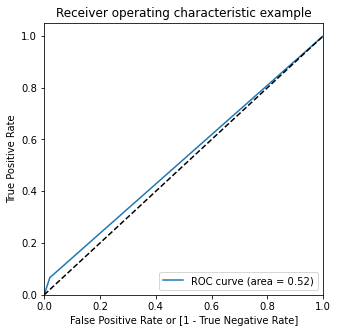

In [86]:
#KNeighborsClassifier
model5=KNeighborsClassifier(n_neighbors=3)
model5.fit(X_train, y_train)
y_pred5 = model5.predict(X_test)
accuracy_score5=accuracy_score(y_test, y_pred5)
print(f'KNeighborsClassifier Model Accuracy: {round(accuracy_score5*100 , 1)} %') 
print(f'KNeighborsClassifier Model Precision: {round(precision_score(y_test,y_pred5)*100 , 1)} %') 
print(f'KNeighborsClassifier Model Recall: {round(recall_score(y_test,y_pred5)*100 , 1)} %') 
print(f'KNeighborsClassifier Model AUC: {metrics.roc_auc_score( y_test, y_pred5 )*100} %') 
confusion5 = metrics.confusion_matrix(y_test, y_pred5 )
TP = confusion5[1,1] # True Positiv 
TN = confusion5[0,0] # True Negative
FP = confusion5[0,1] # False Positive
FN = confusion5[1,0] # False Negative
print(f'KNeighborsClassifier Model Specificity: {(TN / float(TN+FP))*100 } %') 
print(f'KNeighborsClassifier Model Sensitivity: {(TP / float(TP+FN))*100 } %') 
fpr, tpr, thresholds = metrics.roc_curve( y_test, y_pred5,drop_intermediate = False )
auc_score = metrics.roc_auc_score( y_test, y_pred5 )
plt.figure(figsize=(5, 5))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### <div align="left"> <span style="color:brown"> <em></em> 7.4- Feature Slection </span></div>
#### <div align="left"> <span style="color:brown"> <em></em> 7.4.1- High Ranking Feature Slection </span></div>

> **Using RFE Recursive feature elimination reduces model complexity by removing features one by one until the optimal number of features is left. This is achieved by fitting the given machine learning algorithm used in the core of the model, ranking features by importance, discarding the least important features, and re-fitting the model.**

In [87]:
# We choose RandomForestClassifier to fit the model and rank features
rfc = RandomForestClassifier()
selector = RFE(estimator = rfc, n_features_to_select = 100)

In [88]:
selector.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(), n_features_to_select=100)

In [89]:
#Checking if the High Ranking Features are 100
L = list(zip(X_train.columns,selector.support_,selector.ranking_))
len([k for k in L if k[1] == True])

100

In [90]:
cols = X_train.columns[selector.support_]
X_train = X_train[cols]
X_test = X_test[cols]

In [91]:
X_train.shape

(7000, 100)

#### <div align="left"> <span style="color:brown"> <em></em> 7.4.2- Better Feature Slection Based on Variance Inflation Factor  </span></div>
> **The VIF directly measures the ratio of the variance of the entire model to the variance of a model with only the feature in question , Multicollinearity creates a problem because features influencing each other, So we need to remove features with VIF>5 as they are highly correlated and make Multicollinearity**

In [92]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif_df = pd.DataFrame()
vif_df['Feature'] = X_train.columns
vif_df['VIF Value'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif_df['VIF Value'] = round(vif_df['VIF Value'], 2)
vif_df = vif_df.sort_values(by = "VIF Value", ascending = False)
vif_df

,Feature,VIF Value
17,OBS_60_CNT_SOCIAL_CIRCLE,312.75
15,OBS_30_CNT_SOCIAL_CIRCLE,312.14
77,NAME_CONTRACT_TYPE_y_Consumer loans,147.32
26,AMT_GOODS_PRICE_y,113.84
24,AMT_APPLICATION,84.43
88,NAME_PORTFOLIO_Cash,48.42
25,AMT_CREDIT_y,44.09
95,PRODUCT_COMBINATION_Cash,42.10
4,AMT_GOODS_PRICE_x,39.75
2,AMT_CREDIT_x,39.02


In [93]:
#Selecting the features with VIF Greater than 10 to be removed first
remove_features = vif_df.loc[vif_df['VIF Value'] > 10, 'Feature']
list(remove_features)

['OBS_60_CNT_SOCIAL_CIRCLE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'NAME_CONTRACT_TYPE_y_Consumer loans',
 'AMT_GOODS_PRICE_y',
 'AMT_APPLICATION',
 'NAME_PORTFOLIO_Cash',
 'AMT_CREDIT_y',
 'PRODUCT_COMBINATION_Cash',
 'AMT_GOODS_PRICE_x',
 'AMT_CREDIT_x',
 'NAME_PORTFOLIO_POS',
 'REGION_RATING_CLIENT_2',
 'REGION_RATING_CLIENT_W_CITY_2',
 'REGION_RATING_CLIENT_3',
 'CNT_FAM_MEMBERS',
 'NAME_CONTRACT_TYPE_y_Revolving loans',
 'REGION_RATING_CLIENT_W_CITY_3',
 'CNT_CHILDREN',
 'DAYS_LAST_DUE_1ST_VERSION']

In [94]:
X_train.drop(remove_features, axis = 1, inplace = True)
X_test.drop(remove_features, axis = 1, inplace = True)

In [95]:
# Create another dataframe that will contain the names of all the feature variables and their respective VIFs
vif_df2 = pd.DataFrame()
vif_df2['Feature'] = X_train.columns
vif_df2['VIF Value'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif_df2['VIF Value'] = round(vif_df2['VIF Value'], 2)
vif_df2 = vif_df2.sort_values(by = "VIF Value", ascending = False)
vif_df2

,Feature,VIF Value
31,NAME_TYPE_SUITE_x_Unaccompanied,29.26
35,NAME_EDUCATION_TYPE_Secondary / secondary special,15.47
39,NAME_HOUSING_TYPE_House / apartment,11.50
25,DAYS_TERMINATION,9.44
55,REG_CITY_NOT_WORK_CITY_1,9.32
24,DAYS_LAST_DUE,8.98
76,NAME_YIELD_GROUP_middle,5.94
8,LIVE_CITY_NOT_WORK_CITY,5.83
29,NAME_TYPE_SUITE_x_Family,5.75
34,NAME_EDUCATION_TYPE_Higher education,5.54


In [96]:
##Selecting the features with VIF Greater than 5 to be removed first
further_remove_features = vif_df2.loc[vif_df2['VIF Value'] > 5, 'Feature']
list(further_remove_features)

['NAME_TYPE_SUITE_x_Unaccompanied',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_HOUSING_TYPE_House / apartment',
 'DAYS_TERMINATION',
 'REG_CITY_NOT_WORK_CITY_1',
 'DAYS_LAST_DUE',
 'NAME_YIELD_GROUP_middle',
 'LIVE_CITY_NOT_WORK_CITY',
 'NAME_TYPE_SUITE_x_Family',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_FAMILY_STATUS_Married']

In [97]:
#Removing Further Highly correlated Faetures
X_train.drop(further_remove_features, axis = 1, inplace = True)
X_test.drop(further_remove_features, axis = 1, inplace = True)

## <div align="left"> <span style="color:brown"> <em></em> _7.5- Building a Model After Feature Selection_ </span></div>
### <div align="left"> <span style="color:brown"> <em></em> _7.5.1- Using LogisticRegression_ </span></div>

LogisticRegression Model Accuracy: 91.3 %
LogisticRegression Model Precision: 28.6 %
LogisticRegression Model Sensitivity: 0.8 %
LogisticRegression Model AUC: 50.297963971964 %
LogisticRegression Model Specificity: 99.81771782719649 %


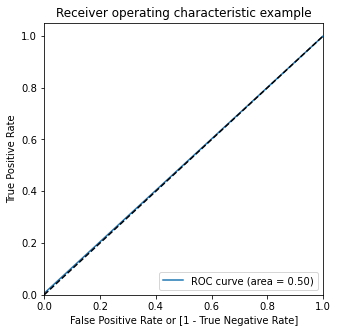

In [98]:
model1=LogisticRegression(random_state=0)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
accuracy_score1=accuracy_score(y_test, y_pred1)
print(f'LogisticRegression Model Accuracy: {round(accuracy_score1*100 , 1)} %') 
#Precision measures true positives over the number of total positives
print(f'LogisticRegression Model Precision: {round(precision_score(y_test,y_pred1)*100 , 1)} %')
#Recall measures true positive over the count of actual positive outcomes.
print(f'LogisticRegression Model Sensitivity: {round(recall_score(y_test,y_pred1)*100 , 1)} %') 
print(f'LogisticRegression Model AUC: {metrics.roc_auc_score( y_test, y_pred1 )*100} %') 
confusion1 = metrics.confusion_matrix(y_test, y_pred1 )
TP = confusion1[1,1] # True Positiv 
TN = confusion1[0,0] # True Negative
FP = confusion1[0,1] # False Positive
FN = confusion1[1,0] # False Negative
print(f'LogisticRegression Model Specificity: {(TN / float(TN+FP))*100 } %') 
#The model precision score measures the proportion of positively predicted labels that are actually correct
#Model recall score represents the model’s ability to correctly predict the positives out of actual positives
#A confusion matrix is used to describe performance of classific. model on data for which the true values are known.
fpr, tpr, thresholds = metrics.roc_curve( y_test, y_pred1,drop_intermediate = False )
auc_score = metrics.roc_auc_score( y_test, y_pred1 )
plt.figure(figsize=(5, 5))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### <div align="left"> <span style="color:brown"> <em></em> _7.5.2- Using DecisionTreeRegressor_ </span></div>

DecisionTreeRegressor Model Accuracy: 83.7 %
DecisionTreeRegressor Model Precision: 11.3 %
DecisionTreeRegressor Model Sensitivity: 13.2 %
DecisionTreeRegressor Model AUC: 51.766080195644804 %
DecisionTreeRegressor Model Specificity: 90.30258840685381 %


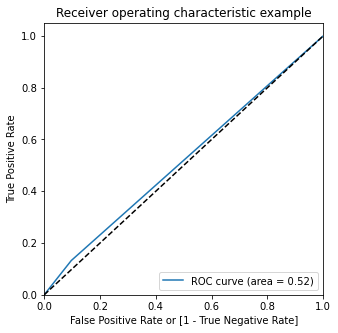

In [99]:
model2=DecisionTreeRegressor(random_state = 0)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
accuracy_score2=accuracy_score(y_test, y_pred2)
print(f'DecisionTreeRegressor Model Accuracy: {round(accuracy_score2*100 , 1)} %') 
print(f'DecisionTreeRegressor Model Precision: {round(precision_score(y_test,y_pred2)*100 , 1)} %') 
print(f'DecisionTreeRegressor Model Sensitivity: {round(recall_score(y_test,y_pred2)*100 , 1)} %') 
print(f'DecisionTreeRegressor Model AUC: {metrics.roc_auc_score( y_test, y_pred2 )*100} %') 
confusion2 = metrics.confusion_matrix(y_test, y_pred2 )
TP = confusion2[1,1] # True Positiv 
TN = confusion2[0,0] # True Negative
FP = confusion2[0,1] # False Positive
FN = confusion2[1,0] # False Negative
print(f'DecisionTreeRegressor Model Specificity: {(TN / float(TN+FP))*100 } %') 
fpr, tpr, thresholds = metrics.roc_curve( y_test, y_pred2,drop_intermediate = False )
auc_score = metrics.roc_auc_score( y_test, y_pred2 )
plt.figure(figsize=(5, 5))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### <div align="left"> <span style="color:brown"> <em></em> _7.5.3- Using RandomForestRegressor_ </span></div>

RandomForestClassifier Model Accuracy: 91.5 %
RandomForestClassifier Model Precision: 100.0 %
RandomForestClassifier Model Sensitivity: 0.8 %
RandomForestClassifier Model AUC: 50.38910505836576 %
RandomForestClassifier Model Specificity: 100.0 %


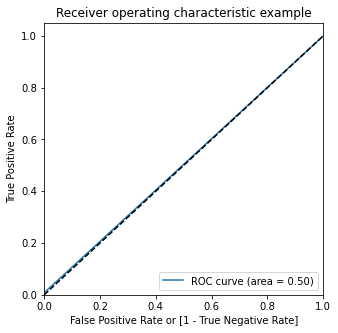

In [100]:
#perfect model 100 % Precision
model3=RandomForestClassifier(random_state = 0)
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
accuracy_score3=accuracy_score(y_test, y_pred3)
print(f'RandomForestClassifier Model Accuracy: {round(accuracy_score3*100 , 1)} %') 
print(f'RandomForestClassifier Model Precision: {round(precision_score(y_test,y_pred3)*100 , 1)} %') 
print(f'RandomForestClassifier Model Sensitivity: {round(recall_score(y_test,y_pred3)*100 , 1)} %') 
print(f'RandomForestClassifier Model AUC: {metrics.roc_auc_score( y_test, y_pred3 )*100} %') 
confusion3 = metrics.confusion_matrix(y_test, y_pred3 )
TP = confusion3[1,1] # True Positiv 
TN = confusion3[0,0] # True Negative
FP = confusion3[0,1] # False Positive
FN = confusion3[1,0] # False Negative
print(f'RandomForestClassifier Model Specificity: {(TN / float(TN+FP))*100 } %') 
fpr, tpr, thresholds = metrics.roc_curve( y_test, y_pred3,drop_intermediate = False )
auc_score = metrics.roc_auc_score( y_test, y_pred3 )
plt.figure(figsize=(5, 5))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### <div align="left"> <span style="color:brown"> <em></em> _7.5.4- Using XGBClassifier_ </span></div>

XGBClassifier Model Accuracy: 91.3 %
XGBClassifier Model Precision: 41.4 %
XGBClassifier Model Sensitivity: 4.7 %
XGBClassifier Model AUC: 52.024750656428594 %
XGBClassifier Model Specificity: 99.3802406124681 %


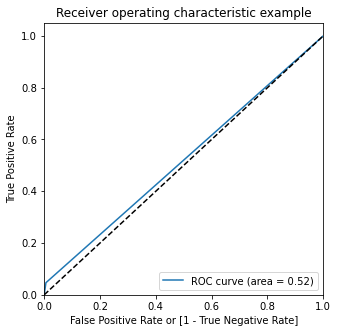

In [101]:
model4=XGBClassifier(random_state=0)
model4.fit(X_train, y_train)
y_pred4 = model4.predict(X_test)
accuracy_score4=accuracy_score(y_test, y_pred4)
print(f'XGBClassifier Model Accuracy: {round(accuracy_score4*100 , 1)} %') 
print(f'XGBClassifier Model Precision: {round(precision_score(y_test,y_pred4)*100 , 1)} %') 
print(f'XGBClassifier Model Sensitivity: {round(recall_score(y_test,y_pred4)*100 , 1)} %')
print(f'XGBClassifier Model AUC: {metrics.roc_auc_score( y_test, y_pred4 )*100} %') 
confusion4 = metrics.confusion_matrix(y_test, y_pred4 )
TP = confusion4[1,1] # True Positiv 
TN = confusion4[0,0] # True Negative
FP = confusion4[0,1] # False Positive
FN = confusion4[1,0] # False Negative
print(f'XGBClassifier Model Specificity: {(TN / float(TN+FP))*100 } %') 
fpr, tpr, thresholds = metrics.roc_curve( y_test, y_pred4,drop_intermediate = False )
auc_score = metrics.roc_auc_score( y_test, y_pred4 )
plt.figure(figsize=(5, 5))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### <div align="left"> <span style="color:brown"> <em></em> _7.5.5- Using KNeighborsClassifier_ </span></div>

KNeighborsClassifier Model Accuracy: 90.9 %
KNeighborsClassifier Model Precision: 22.6 %
KNeighborsClassifier Model Recall: 2.7 %
KNeighborsClassifier Model AUC: 50.924390489551755 %
KNeighborsClassifier Model Specificity: 99.12504557054321 %
KNeighborsClassifier Model Sensitivity: 2.7237354085603114 %


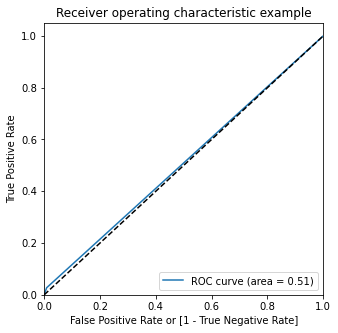

In [102]:
#KNeighborsClassifier Tuning ..
model5=KNeighborsClassifier(n_neighbors=5,p=4,algorithm='ball_tree')
model5.fit(X_train, y_train)
y_pred5 = model5.predict(X_test)
accuracy_score5=accuracy_score(y_test, y_pred5)
print(f'KNeighborsClassifier Model Accuracy: {round(accuracy_score5*100 , 1)} %') 
print(f'KNeighborsClassifier Model Precision: {round(precision_score(y_test,y_pred5)*100 , 1)} %') 
print(f'KNeighborsClassifier Model Recall: {round(recall_score(y_test,y_pred5)*100 , 1)} %')
print(f'KNeighborsClassifier Model AUC: {metrics.roc_auc_score( y_test, y_pred5)*100} %') 
confusion5 = metrics.confusion_matrix(y_test, y_pred5 )
TP = confusion5[1,1] # True Positiv 
TN = confusion5[0,0] # True Negative
FP = confusion5[0,1] # False Positive
FN = confusion5[1,0] # False Negative
print(f'KNeighborsClassifier Model Specificity: {(TN / float(TN+FP))*100 } %') 
print(f'KNeighborsClassifier Model Sensitivity: {(TP / float(TP+FN))*100 } %') 
fpr, tpr, thresholds = metrics.roc_curve( y_test, y_pred5,drop_intermediate = False )
auc_score = metrics.roc_auc_score( y_test, y_pred5 )
plt.figure(figsize=(5, 5))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()